![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmedia.licdn.com%2Fdms%2Fimage%2Fv2%2FD4D12AQGKTnekj4UbrA%2Farticle-cover_image-shrink_720_1280%2FB4DZsEXnKeIAAM-%2F0%2F1765304857767%3Fe%3D2147483647%26v%3Dbeta%26t%3DtUMbL8kpBRsAtLFAeYb4yc7ZSI8ldiVEWEVT9jJ2K9U&f=1&nofb=1&ipt=b453b60baf4f22aa711ef8bb2e76e80ce1a409a5859c1e6e50eddd0ca59ea379)

---

### Why This Project Matters

**Business Context:** Accurate demand forecasting is the backbone of retail operations. Poor forecasts lead to:
- **Overstocking** → Tied-up capital, spoilage (especially perishables)
- **Understocking** → Lost sales, unhappy customers

**Technical Challenge:** This is a hierarchical forecasting problem with:
- 54 stores × 33 product families = **1,782 individual time series**
- External factors: holidays, oil prices, promotions, economic conditions
- Ecuador-specific dynamics (oil-dependent economy, regional holidays)

---

### Project Goals
1. **Demonstrate proper time series methodology** — No data leakage, time-based validation
2. **Compare multiple approaches** — Statistical (SARIMA) vs. Modern (Prophet) vs. ML (XGBoost, LightGBM)
3. **Engineer domain-aware features** — Lag features, rolling statistics, holiday effects, oil price impact
4. **Deliver actionable forecasts** — 16-day ahead predictions with confidence intervals
5. **Production-ready code** — Modular, documented, deployment-ready

---

### Table of Contents
1. [Setup & Data Loading](#setup)
2. [Exploratory Data Analysis](#eda)
3. [Time Series Analysis](#ts-analysis)
4. [Feature Engineering](#feature-engineering)
5. [Modeling](#modeling)
   - Baseline Models
   - SARIMA (Classical Time Series)
   - Facebook Prophet
   - XGBoost with Lag Features
   - LightGBM with Lag Features
6. [Model Evaluation & Comparison](#evaluation)
7. [Final Forecasts](#forecasts)
8. [Business Impact Analysis](#business)
9. [Conclusions & Recommendations](#conclusions)

---
<a id="setup"></a>
## 1. 🔧 Setup & Data Loading

First, we import libraries and load all datasets. The pipeline is designed to handle the full 3M+ row dataset efficiently.

In [16]:
# ============================================================
# IMPORTS
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine Learning
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

# Gradient Boosting
import xgboost as xgb
from xgboost import XGBRegressor

# LightGBM
try:
    import lightgbm as lgb
    LGBM_AVAILABLE = True
except ImportError:
    print("LightGBM not installed. Install with: pip install lightgbm")
    LGBM_AVAILABLE = False

# Prophet
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    print("Prophet not installed. Install with: pip install prophet")
    PROPHET_AVAILABLE = False

# Model persistence
import joblib
import pickle

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72', 
    'accent': '#F18F01',
    'success': '#28A745',
    'danger': '#DC3545',
    'dark': '#1B1B1E'
}

print("✅ Libraries loaded successfully!")
print(f"   Prophet available: {PROPHET_AVAILABLE}")
print(f"   LightGBM available: {LGBM_AVAILABLE}")

✅ Libraries loaded successfully!
   Prophet available: True
   LightGBM available: True


In [17]:
# ============================================================
# DATA LOADING
# ============================================================
DATA_PATH = '/kaggle/input/store-sales-time-series-forecasting/'  # Kaggle default
# DATA_PATH = 'data/'  # Uncomment for local

# Memory-efficient loading with proper dtypes
dtype_dict = {
    'id': 'int32',
    'store_nbr': 'int8',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'int16'
}

print("Loading datasets...")

# Main training data
train = pd.read_csv(f'{DATA_PATH}train.csv', 
                    dtype=dtype_dict,
                    parse_dates=['date'])

# Supplementary data
stores = pd.read_csv(f'{DATA_PATH}stores.csv')
oil = pd.read_csv(f'{DATA_PATH}oil.csv', parse_dates=['date'])
holidays = pd.read_csv(f'{DATA_PATH}holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv(f'{DATA_PATH}transactions.csv', parse_dates=['date'])
test = pd.read_csv(f'{DATA_PATH}test.csv', parse_dates=['date'])

print(f"✅ Data loaded successfully!")
print(f"   Train shape: {train.shape[0]:,} rows × {train.shape[1]} columns")
print(f"   Test shape: {test.shape[0]:,} rows × {test.shape[1]} columns")
print(f"   Date range: {train['date'].min().date()} to {train['date'].max().date()}")
print(f"   Stores: {train['store_nbr'].nunique()}")
print(f"   Product families: {train['family'].nunique()}")
print(f"   Memory usage: {train.memory_usage(deep=True).sum() / 1e6:.1f} MB")

Loading datasets...
✅ Data loaded successfully!
   Train shape: 3,000,888 rows × 6 columns
   Test shape: 28,512 rows × 5 columns
   Date range: 2013-01-01 to 2017-08-15
   Stores: 54
   Product families: 33
   Memory usage: 60.0 MB


---
<a id="eda"></a>
## 2. 📊 Exploratory Data Analysis

Understanding the data before modeling is critical. We'll examine:
- Overall sales trends
- Seasonal patterns
- Store and product family distributions
- Impact of holidays and promotions

In [18]:
# ============================================================
# DATA OVERVIEW
# ============================================================
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)

print("\n📋 Train Data Sample:")
display(train.head(10))

print("\n📋 Data Types:")
print(train.dtypes)

print("\n📋 Missing Values:")
print(train.isnull().sum())

print("\n📋 Sales Statistics:")
print(train['sales'].describe())

# Check for negative sales
neg_sales = (train['sales'] < 0).sum()
print(f"\n⚠️ Negative sales entries: {neg_sales:,}")

# Zero sales percentage
zero_sales = (train['sales'] == 0).mean() * 100
print(f"📊 Zero sales percentage: {zero_sales:.1f}%")

DATASET OVERVIEW

📋 Train Data Sample:


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0



📋 Data Types:
id                      int32
date           datetime64[ns]
store_nbr                int8
family               category
sales                 float32
onpromotion             int16
dtype: object

📋 Missing Values:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

📋 Sales Statistics:
count    3.000888e+06
mean     3.577757e+02
std      1.092778e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

⚠️ Negative sales entries: 0
📊 Zero sales percentage: 31.3%


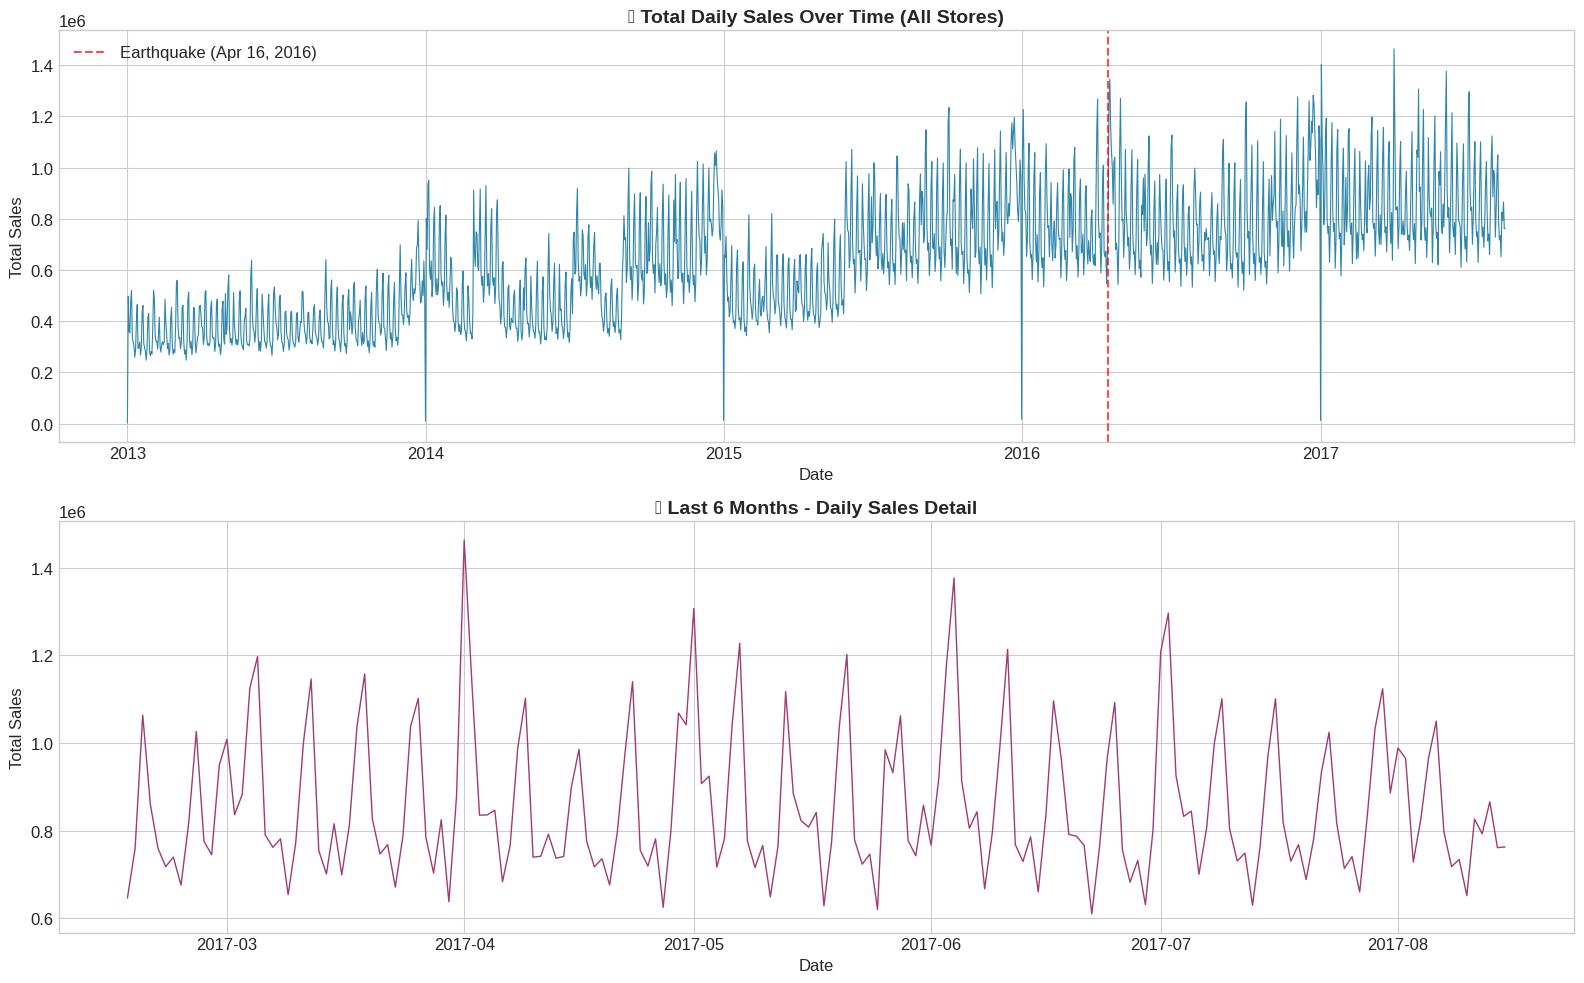


💡 Key Observations:
   • Clear weekly seasonality (lower sales on certain days)
   • Annual seasonality (December peaks)
   • Earthquake impact visible in April 2016
   • Overall upward trend in sales


In [19]:
# ============================================================
# AGGREGATE SALES OVER TIME
# ============================================================
daily_sales = train.groupby('date')['sales'].sum().reset_index()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Full time series
ax1 = axes[0]
ax1.plot(daily_sales['date'], daily_sales['sales'], color=COLORS['primary'], linewidth=0.8)
ax1.set_title('📈 Total Daily Sales Over Time (All Stores)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales')
ax1.axvline(pd.Timestamp('2016-04-16'), color='red', linestyle='--', alpha=0.7, label='Earthquake (Apr 16, 2016)')
ax1.legend()

# Last 6 months (more detail)
last_6m = daily_sales[daily_sales['date'] >= daily_sales['date'].max() - pd.Timedelta(days=180)]
ax2 = axes[1]
ax2.plot(last_6m['date'], last_6m['sales'], color=COLORS['secondary'], linewidth=1)
ax2.set_title('📈 Last 6 Months - Daily Sales Detail', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Total Sales')

plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print("   • Clear weekly seasonality (lower sales on certain days)")
print("   • Annual seasonality (December peaks)")
print("   • Earthquake impact visible in April 2016")
print("   • Overall upward trend in sales")

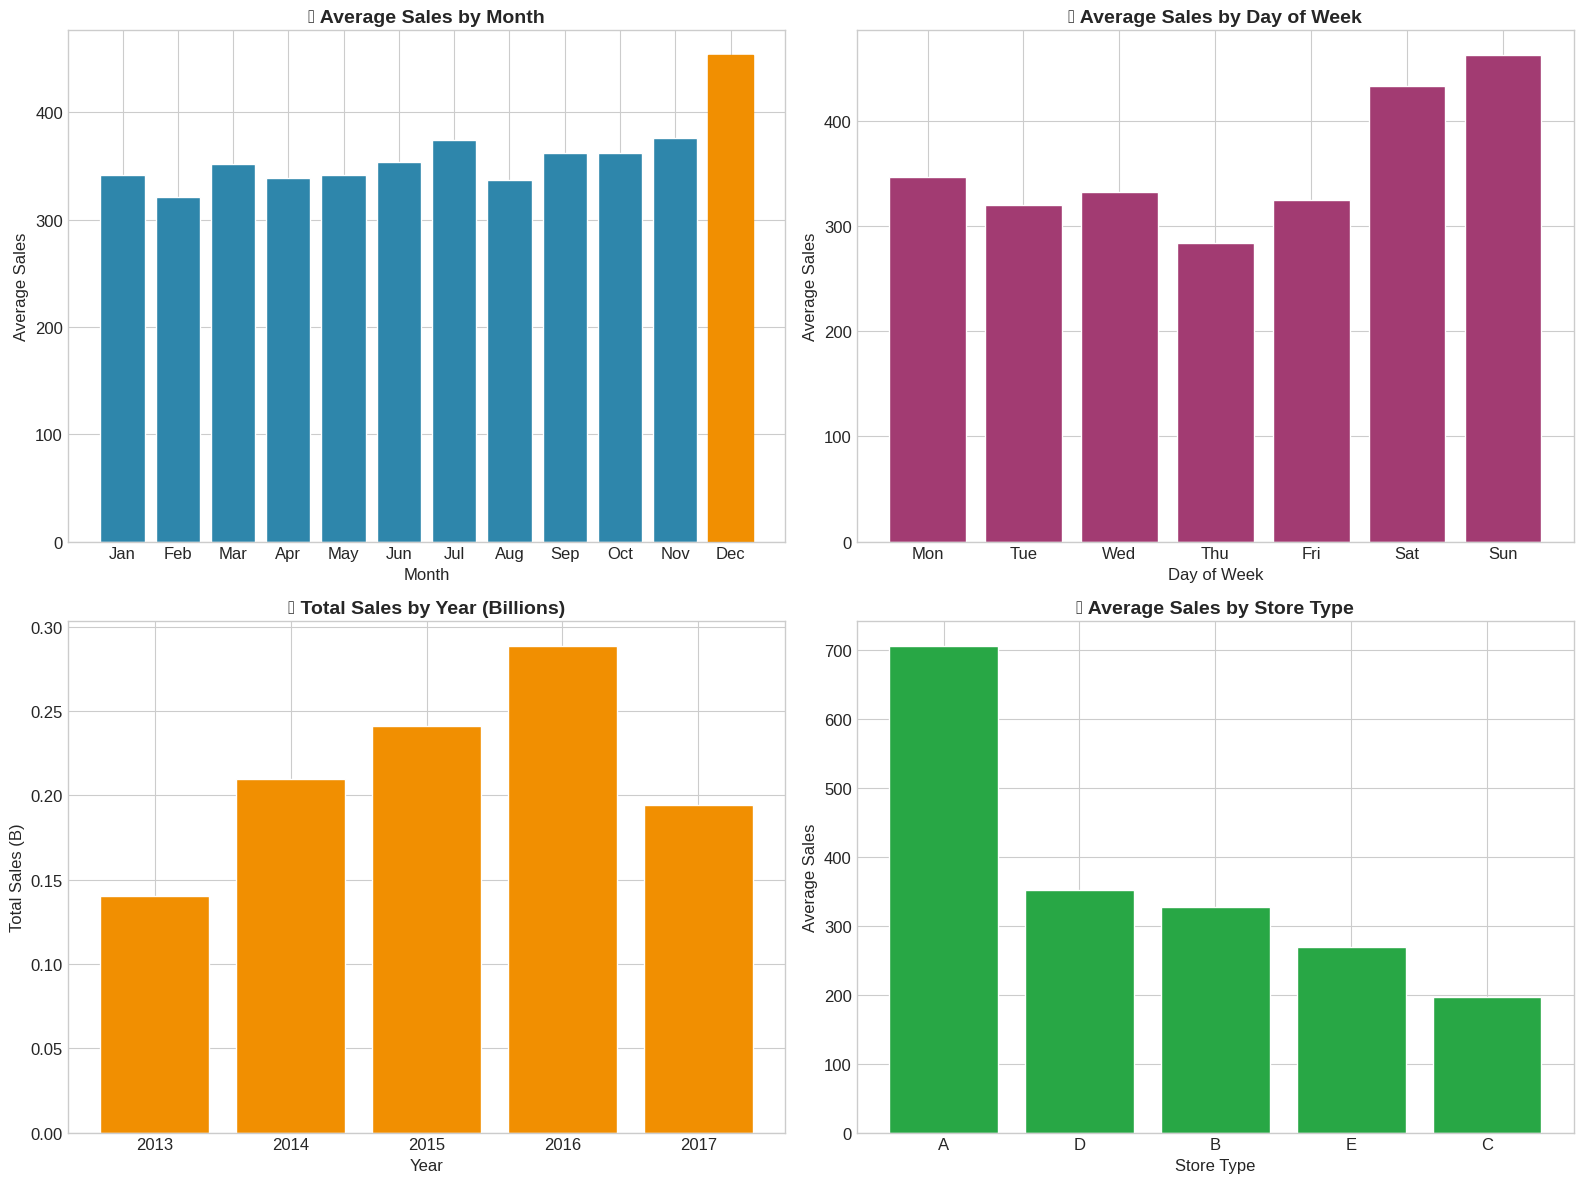


💡 Seasonality Insights:
   • December shows highest sales (holiday shopping)
   • Sunday has notably lower sales
   • Saturday is the peak day
   • Type A stores have highest average sales


In [20]:
# ============================================================
# SEASONALITY ANALYSIS
# ============================================================
train_analysis = train.copy()
train_analysis['year'] = train_analysis['date'].dt.year
train_analysis['month'] = train_analysis['date'].dt.month
train_analysis['dayofweek'] = train_analysis['date'].dt.dayofweek
train_analysis['day'] = train_analysis['date'].dt.day
train_analysis['weekofyear'] = train_analysis['date'].dt.isocalendar().week.astype(int)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Monthly seasonality
monthly = train_analysis.groupby('month')['sales'].mean()
ax1 = axes[0, 0]
bars = ax1.bar(monthly.index, monthly.values, color=COLORS['primary'], edgecolor='white')
ax1.set_title('📅 Average Sales by Month', fontsize=14, fontweight='bold')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Sales')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
bars[11].set_color(COLORS['accent'])  # Highlight December

# Day of week seasonality
dow = train_analysis.groupby('dayofweek')['sales'].mean()
ax2 = axes[0, 1]
ax2.bar(dow.index, dow.values, color=COLORS['secondary'], edgecolor='white')
ax2.set_title('📅 Average Sales by Day of Week', fontsize=14, fontweight='bold')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Average Sales')
ax2.set_xticks(range(7))
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Yearly trend
yearly = train_analysis.groupby('year')['sales'].sum() / 1e9
ax3 = axes[1, 0]
ax3.bar(yearly.index.astype(str), yearly.values, color=COLORS['accent'], edgecolor='white')
ax3.set_title('📅 Total Sales by Year (Billions)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Total Sales (B)')

# Store type comparison
train_with_stores = train.merge(stores[['store_nbr', 'type']], on='store_nbr')
store_type_sales = train_with_stores.groupby('type')['sales'].mean().sort_values(ascending=False)
ax4 = axes[1, 1]
ax4.bar(store_type_sales.index, store_type_sales.values, color=COLORS['success'], edgecolor='white')
ax4.set_title('📅 Average Sales by Store Type', fontsize=14, fontweight='bold')
ax4.set_xlabel('Store Type')
ax4.set_ylabel('Average Sales')

plt.tight_layout()
plt.show()

print("\n💡 Seasonality Insights:")
print("   • December shows highest sales (holiday shopping)")
print("   • Sunday has notably lower sales")
print("   • Saturday is the peak day")
print("   • Type A stores have highest average sales")

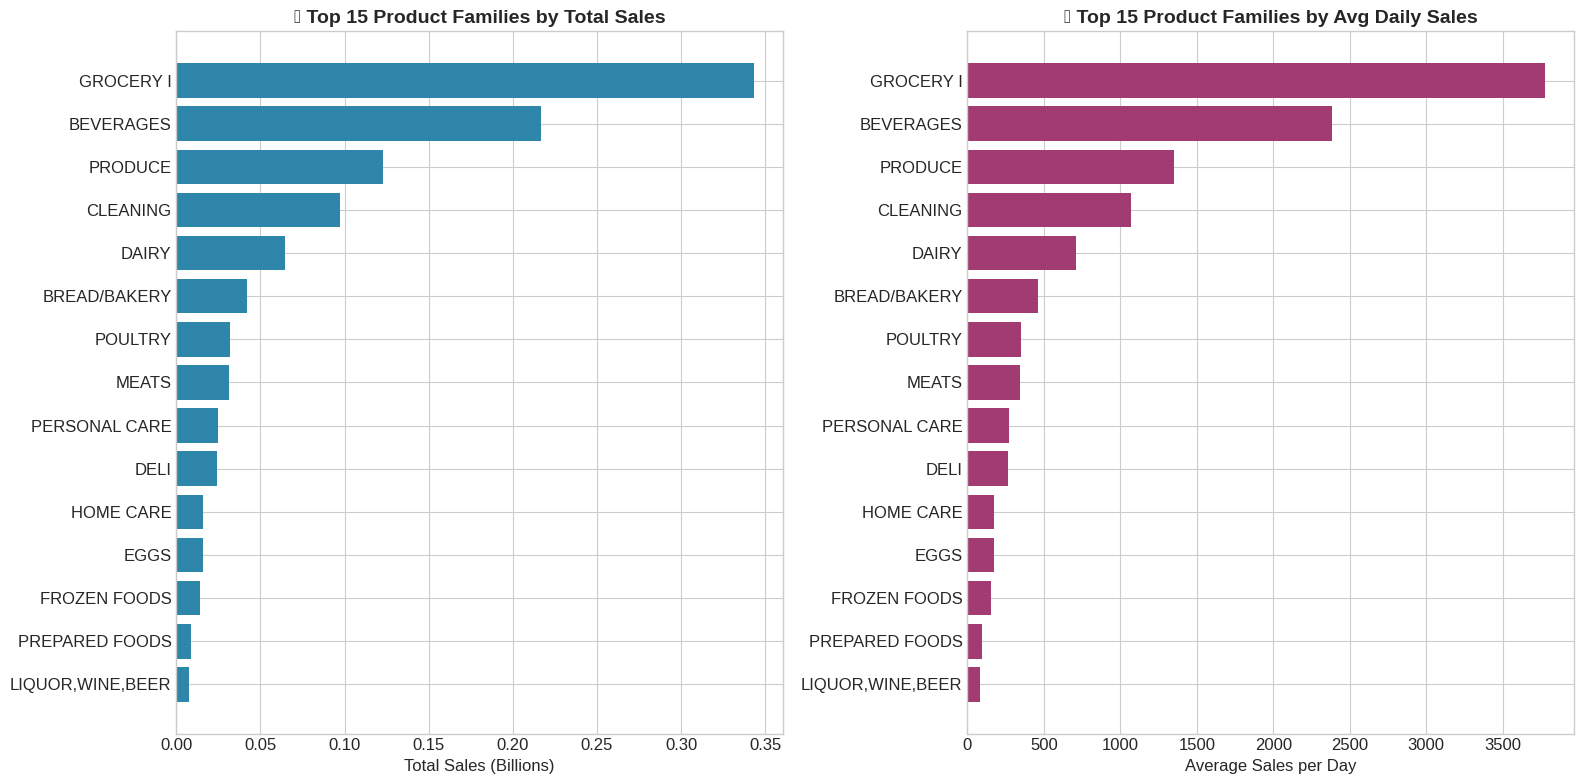


💡 Product Insights:
   • GROCERY I dominates total sales volume
   • BEVERAGES and PRODUCE are also major categories
   • Some categories like BOOKS, BABY CARE have low volume


In [21]:
# ============================================================
# TOP PRODUCT FAMILIES
# ============================================================
family_sales = train.groupby('family')['sales'].agg(['sum', 'mean']).sort_values('sum', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 15 by total sales
top_15 = family_sales.head(15)
ax1 = axes[0]
ax1.barh(range(len(top_15)), top_15['sum'].values / 1e9, color=COLORS['primary'])
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15.index)
ax1.invert_yaxis()
ax1.set_title('🏆 Top 15 Product Families by Total Sales', fontsize=14, fontweight='bold')
ax1.set_xlabel('Total Sales (Billions)')

# Average sales per record
ax2 = axes[1]
top_15_mean = family_sales.head(15).sort_values('mean', ascending=False)
ax2.barh(range(len(top_15_mean)), top_15_mean['mean'].values, color=COLORS['secondary'])
ax2.set_yticks(range(len(top_15_mean)))
ax2.set_yticklabels(top_15_mean.index)
ax2.invert_yaxis()
ax2.set_title('🏆 Top 15 Product Families by Avg Daily Sales', fontsize=14, fontweight='bold')
ax2.set_xlabel('Average Sales per Day')

plt.tight_layout()
plt.show()

print("\n💡 Product Insights:")
print("   • GROCERY I dominates total sales volume")
print("   • BEVERAGES and PRODUCE are also major categories")
print("   • Some categories like BOOKS, BABY CARE have low volume")

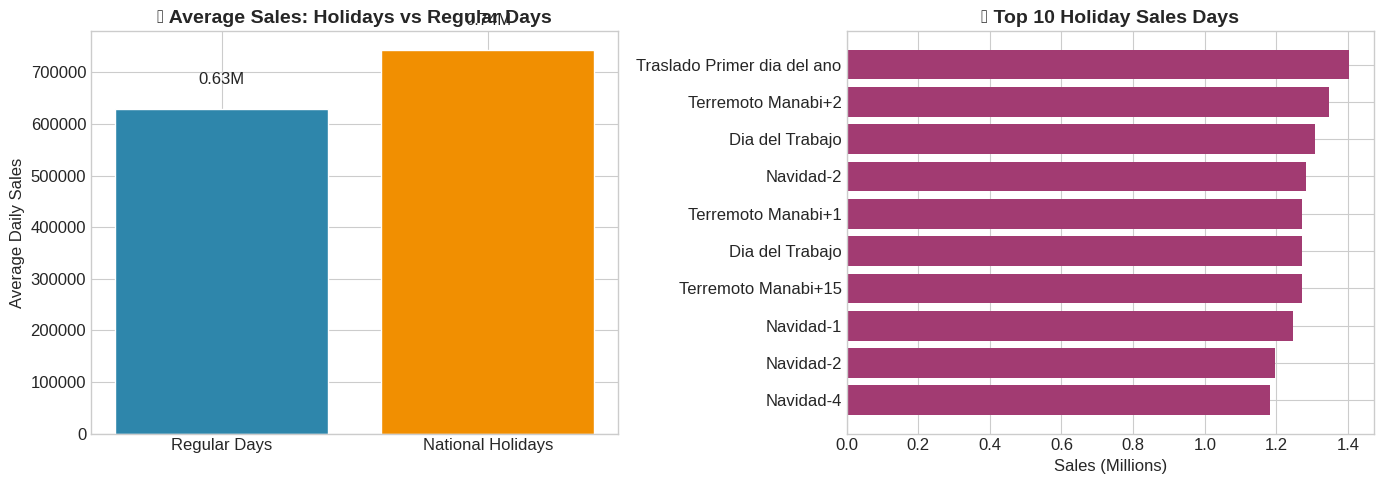


💡 Holiday Impact: +18.2% sales change on holidays


In [22]:
# ============================================================
# HOLIDAY IMPACT ANALYSIS
# ============================================================
holidays_national = holidays[holidays['locale'] == 'National'].copy()
holidays_national['is_holiday'] = 1

daily_sales_holidays = daily_sales.merge(
    holidays_national[['date', 'is_holiday', 'description']], 
    on='date', 
    how='left'
)
daily_sales_holidays['is_holiday'] = daily_sales_holidays['is_holiday'].fillna(0)

# Compare holiday vs non-holiday sales
holiday_comparison = daily_sales_holidays.groupby('is_holiday')['sales'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar comparison
ax1 = axes[0]
bars = ax1.bar(['Regular Days', 'National Holidays'], holiday_comparison.values, 
               color=[COLORS['primary'], COLORS['accent']], edgecolor='white')
ax1.set_title('📊 Average Sales: Holidays vs Regular Days', fontsize=14, fontweight='bold')
ax1.set_ylabel('Average Daily Sales')
for bar, val in zip(bars, holiday_comparison.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50000, 
             f'{val/1e6:.2f}M', ha='center', fontsize=12)

# Top holiday sales
top_holidays = daily_sales_holidays[daily_sales_holidays['is_holiday'] == 1].nlargest(10, 'sales')
ax2 = axes[1]
ax2.barh(range(len(top_holidays)), top_holidays['sales'].values / 1e6, color=COLORS['secondary'])
ax2.set_yticks(range(len(top_holidays)))
ax2.set_yticklabels([d[:30] for d in top_holidays['description'].values])
ax2.invert_yaxis()
ax2.set_title('🏆 Top 10 Holiday Sales Days', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sales (Millions)')

plt.tight_layout()
plt.show()

# Holiday impact percentage
holiday_lift = (holiday_comparison[1] - holiday_comparison[0]) / holiday_comparison[0] * 100
print(f"\n💡 Holiday Impact: {holiday_lift:+.1f}% sales change on holidays")

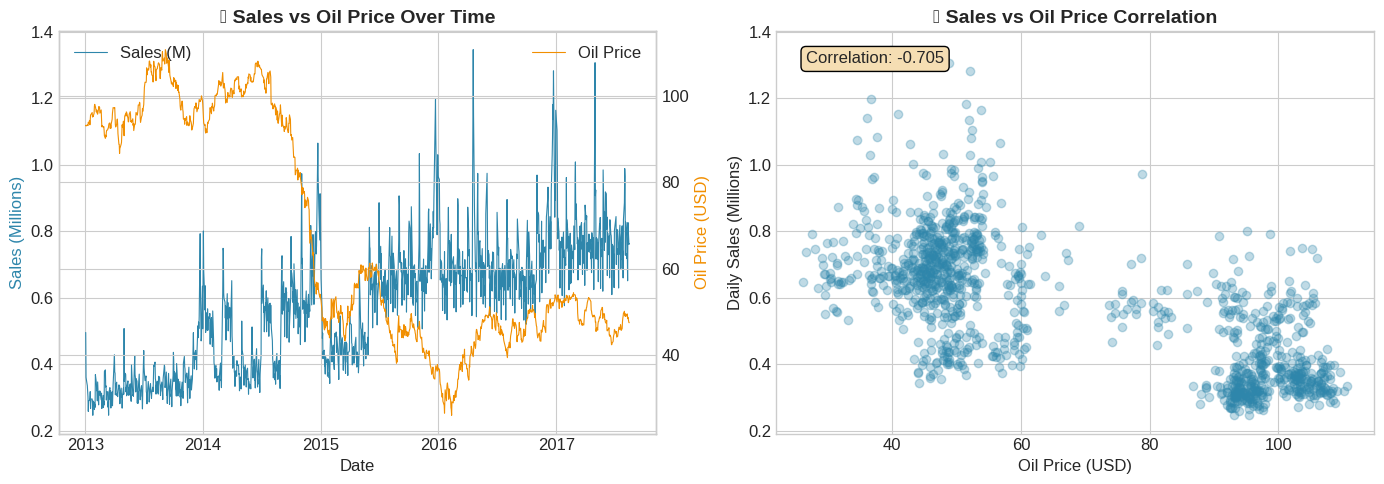


💡 Oil Price Correlation: -0.705
   Ecuador's economy is oil-dependent, explaining the relationship


In [23]:
# ============================================================
# OIL PRICE CORRELATION
# ============================================================
oil_clean = oil.dropna()
oil_sales = daily_sales.merge(oil_clean, on='date', how='inner')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series of both
ax1 = axes[0]
ax1_twin = ax1.twinx()

ax1.plot(oil_sales['date'], oil_sales['sales'] / 1e6, color=COLORS['primary'], label='Sales (M)', linewidth=0.8)
ax1_twin.plot(oil_sales['date'], oil_sales['dcoilwtico'], color=COLORS['accent'], label='Oil Price', linewidth=0.8)

ax1.set_xlabel('Date')
ax1.set_ylabel('Sales (Millions)', color=COLORS['primary'])
ax1_twin.set_ylabel('Oil Price (USD)', color=COLORS['accent'])
ax1.set_title('📈 Sales vs Oil Price Over Time', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Correlation scatter
ax2 = axes[1]
ax2.scatter(oil_sales['dcoilwtico'], oil_sales['sales'] / 1e6, alpha=0.3, color=COLORS['primary'])
ax2.set_xlabel('Oil Price (USD)')
ax2.set_ylabel('Daily Sales (Millions)')
ax2.set_title('📊 Sales vs Oil Price Correlation', fontsize=14, fontweight='bold')

# Add correlation coefficient
corr = oil_sales['dcoilwtico'].corr(oil_sales['sales'])
ax2.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax2.transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

plt.tight_layout()
plt.show()

print(f"\n💡 Oil Price Correlation: {corr:.3f}")
print("   Ecuador's economy is oil-dependent, explaining the relationship")

---
<a id="ts-analysis"></a>
## 3. 📈 Time Series Analysis

Before modeling, we need to understand the statistical properties of our time series:
- **Stationarity** — Is the mean/variance constant over time?
- **Autocorrelation** — How do past values predict future values?
- **Seasonality** — What periodic patterns exist?

📊 Sample Time Series: Store 44 - GROCERY I
   Records: 1,684
   Date Range: 2013-01-01 to 2017-08-15
   Mean Sales: 9,730
   Std Sales: 3,576


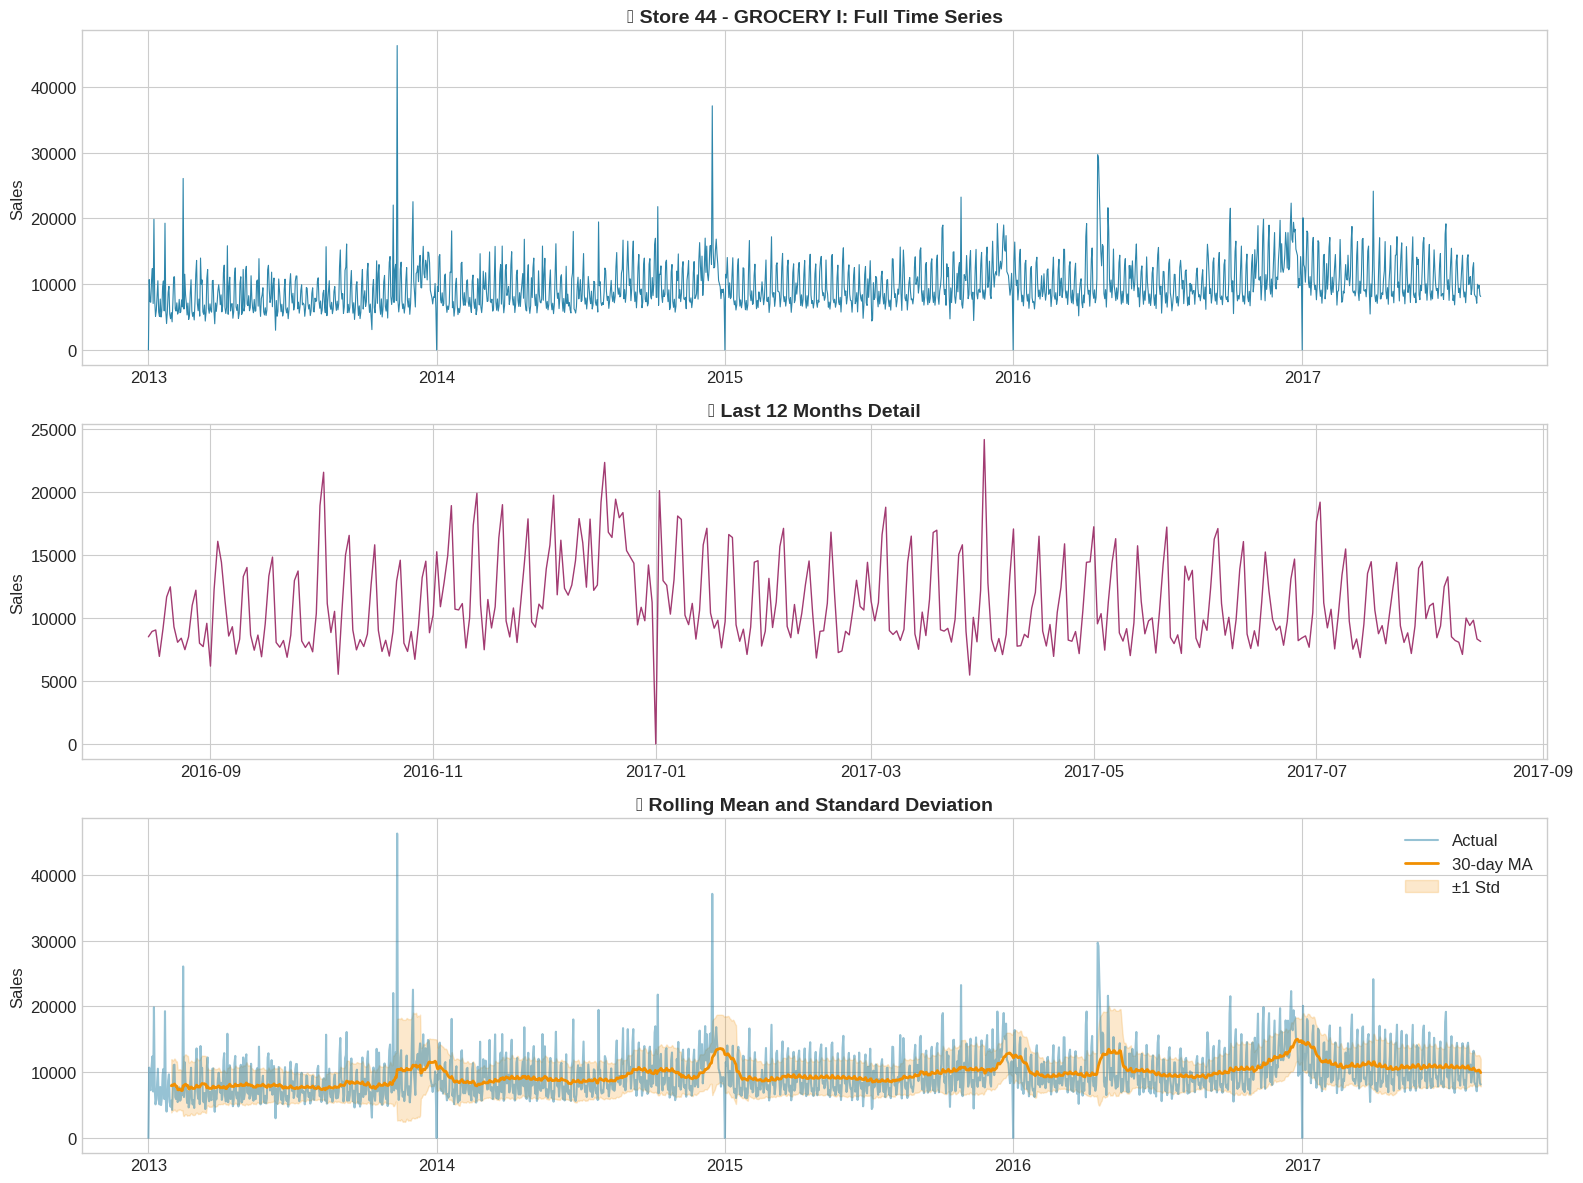

In [24]:
# ============================================================
# FOCUS ON A SINGLE STORE-FAMILY FOR DETAILED ANALYSIS
# ============================================================
# Select Store 44 (Type A in Quito) + GROCERY I (highest volume)

sample_ts = train[(train['store_nbr'] == 44) & (train['family'] == 'GROCERY I')].copy()
sample_ts = sample_ts.sort_values('date').set_index('date')

print(f"📊 Sample Time Series: Store 44 - GROCERY I")
print(f"   Records: {len(sample_ts):,}")
print(f"   Date Range: {sample_ts.index.min().date()} to {sample_ts.index.max().date()}")
print(f"   Mean Sales: {sample_ts['sales'].mean():,.0f}")
print(f"   Std Sales: {sample_ts['sales'].std():,.0f}")

# Plot the time series
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Full series
axes[0].plot(sample_ts.index, sample_ts['sales'], color=COLORS['primary'], linewidth=0.8)
axes[0].set_title('📈 Store 44 - GROCERY I: Full Time Series', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Sales')

# Last year
last_year = sample_ts[sample_ts.index >= sample_ts.index.max() - pd.Timedelta(days=365)]
axes[1].plot(last_year.index, last_year['sales'], color=COLORS['secondary'], linewidth=1)
axes[1].set_title('📈 Last 12 Months Detail', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Sales')

# Rolling statistics
rolling_mean = sample_ts['sales'].rolling(window=30).mean()
rolling_std = sample_ts['sales'].rolling(window=30).std()

axes[2].plot(sample_ts.index, sample_ts['sales'], color=COLORS['primary'], alpha=0.5, label='Actual')
axes[2].plot(rolling_mean.index, rolling_mean, color=COLORS['accent'], linewidth=2, label='30-day MA')
axes[2].fill_between(rolling_std.index, rolling_mean - rolling_std, rolling_mean + rolling_std, 
                     color=COLORS['accent'], alpha=0.2, label='±1 Std')
axes[2].set_title('📈 Rolling Mean and Standard Deviation', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Sales')
axes[2].legend()

plt.tight_layout()
plt.show()

In [25]:
# ============================================================
# STATIONARITY TEST (Augmented Dickey-Fuller)
# ============================================================
def adf_test(series, name=''):
    """Perform Augmented Dickey-Fuller test for stationarity"""
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"\n📊 ADF Test Results: {name}")
    print("=" * 50)
    print(f"   Test Statistic: {result[0]:.4f}")
    print(f"   p-value: {result[1]:.6f}")
    print(f"   Lags Used: {result[2]}")
    print(f"   Observations: {result[3]}")
    print("   Critical Values:")
    for key, value in result[4].items():
        print(f"      {key}: {value:.4f}")
    
    if result[1] < 0.05:
        print("\n   ✅ RESULT: Series is STATIONARY (reject null hypothesis)")
    else:
        print("\n   ⚠️ RESULT: Series is NON-STATIONARY (fail to reject null)")
    
    return result[1] < 0.05

# Test original series
is_stationary = adf_test(sample_ts['sales'], 'Original Sales')

# Test differenced series
sample_ts['sales_diff'] = sample_ts['sales'].diff()
is_stationary_diff = adf_test(sample_ts['sales_diff'], 'First Difference')


📊 ADF Test Results: Original Sales
   Test Statistic: -4.9250
   p-value: 0.000031
   Lags Used: 22
   Observations: 1661
   Critical Values:
      1%: -3.4343
      5%: -2.8633
      10%: -2.5677

   ✅ RESULT: Series is STATIONARY (reject null hypothesis)

📊 ADF Test Results: First Difference
   Test Statistic: -15.1607
   p-value: 0.000000
   Lags Used: 19
   Observations: 1663
   Critical Values:
      1%: -3.4343
      5%: -2.8633
      10%: -2.5677

   ✅ RESULT: Series is STATIONARY (reject null hypothesis)


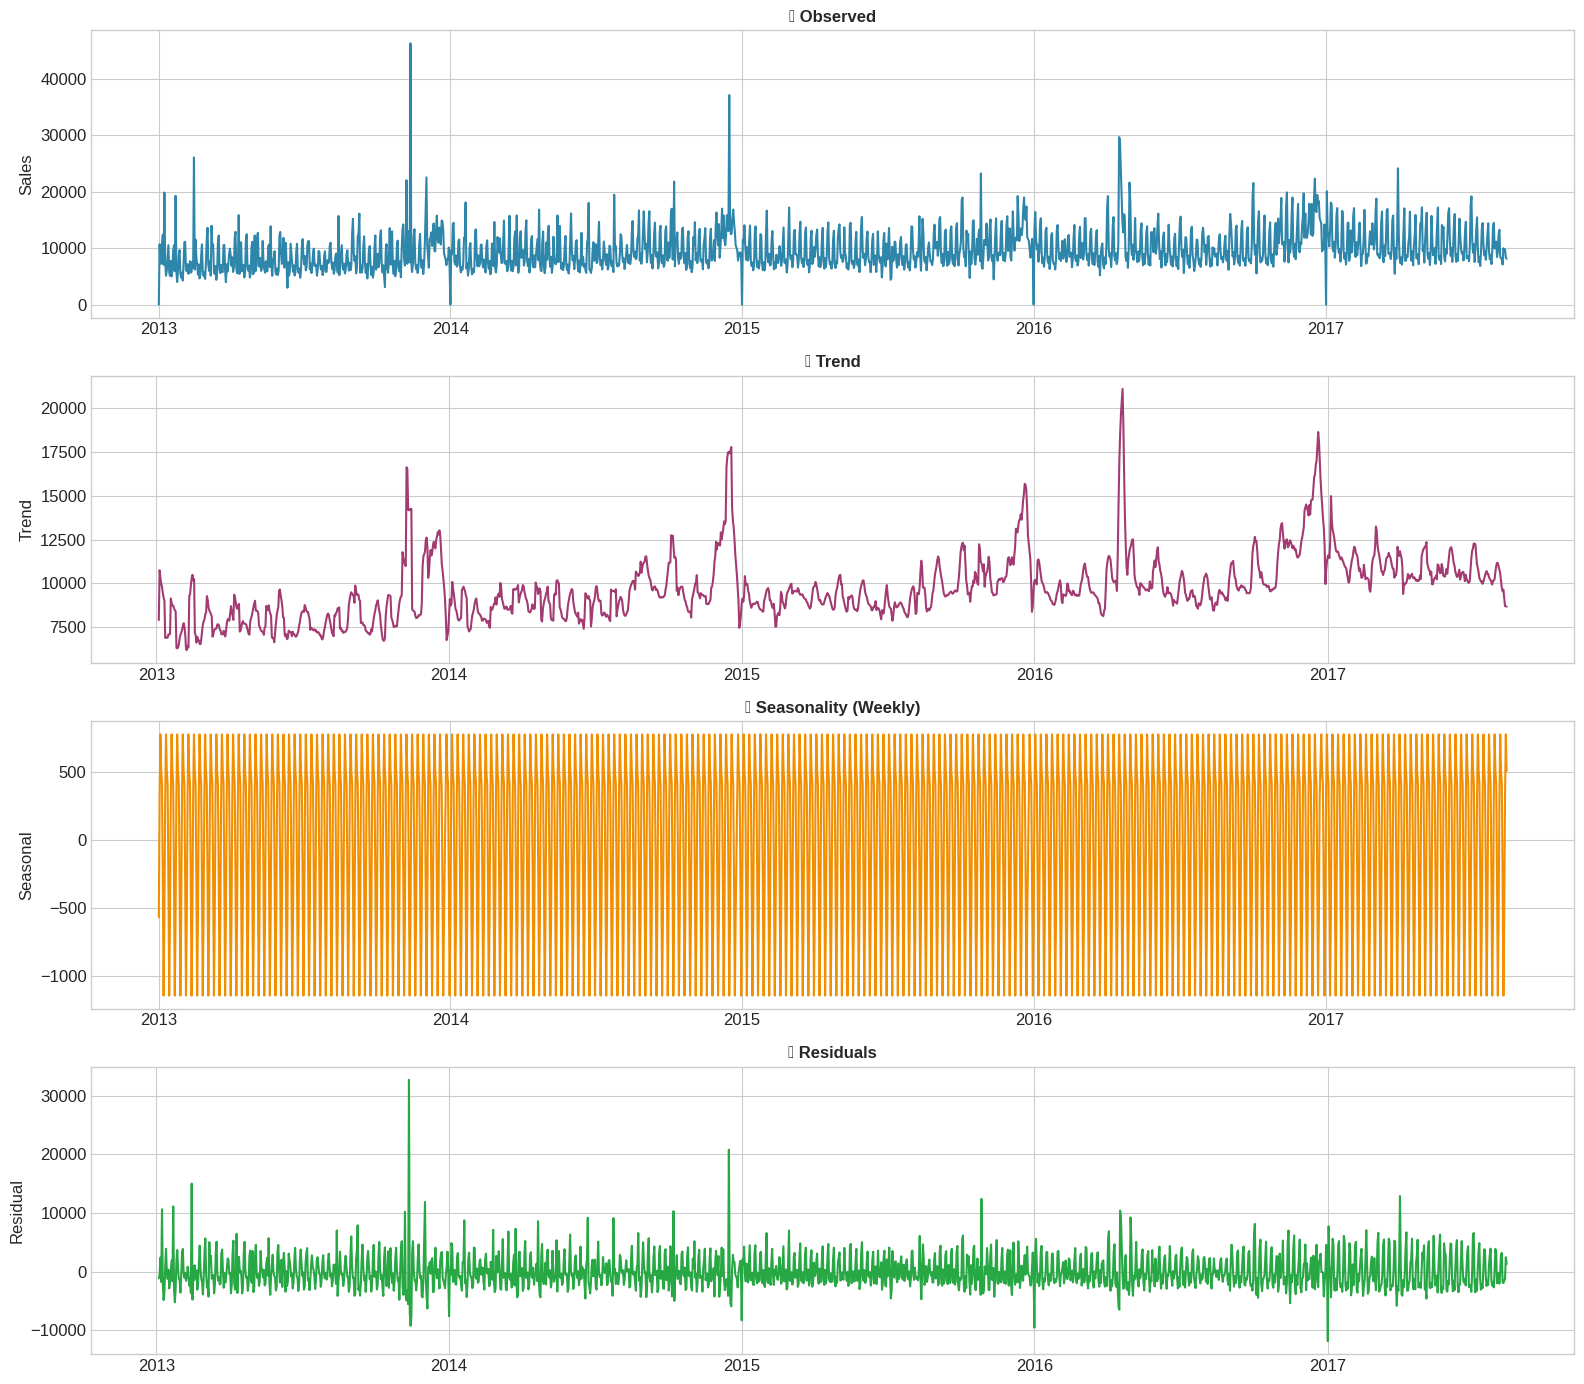


💡 Decomposition Insights:
   • Clear upward TREND over time
   • Strong weekly SEASONALITY (7-day pattern)
   • Residuals show some remaining patterns (could capture with more features)


In [26]:
# ============================================================
# SEASONAL DECOMPOSITION
# ============================================================
decomposition = seasonal_decompose(sample_ts['sales'].dropna(), model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(16, 14))

axes[0].plot(decomposition.observed, color=COLORS['primary'])
axes[0].set_title('📊 Observed', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Sales')

axes[1].plot(decomposition.trend, color=COLORS['secondary'])
axes[1].set_title('📊 Trend', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Trend')

axes[2].plot(decomposition.seasonal, color=COLORS['accent'])
axes[2].set_title('📊 Seasonality (Weekly)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Seasonal')

axes[3].plot(decomposition.resid, color=COLORS['success'])
axes[3].set_title('📊 Residuals', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

print("\n💡 Decomposition Insights:")
print("   • Clear upward TREND over time")
print("   • Strong weekly SEASONALITY (7-day pattern)")
print("   • Residuals show some remaining patterns (could capture with more features)")

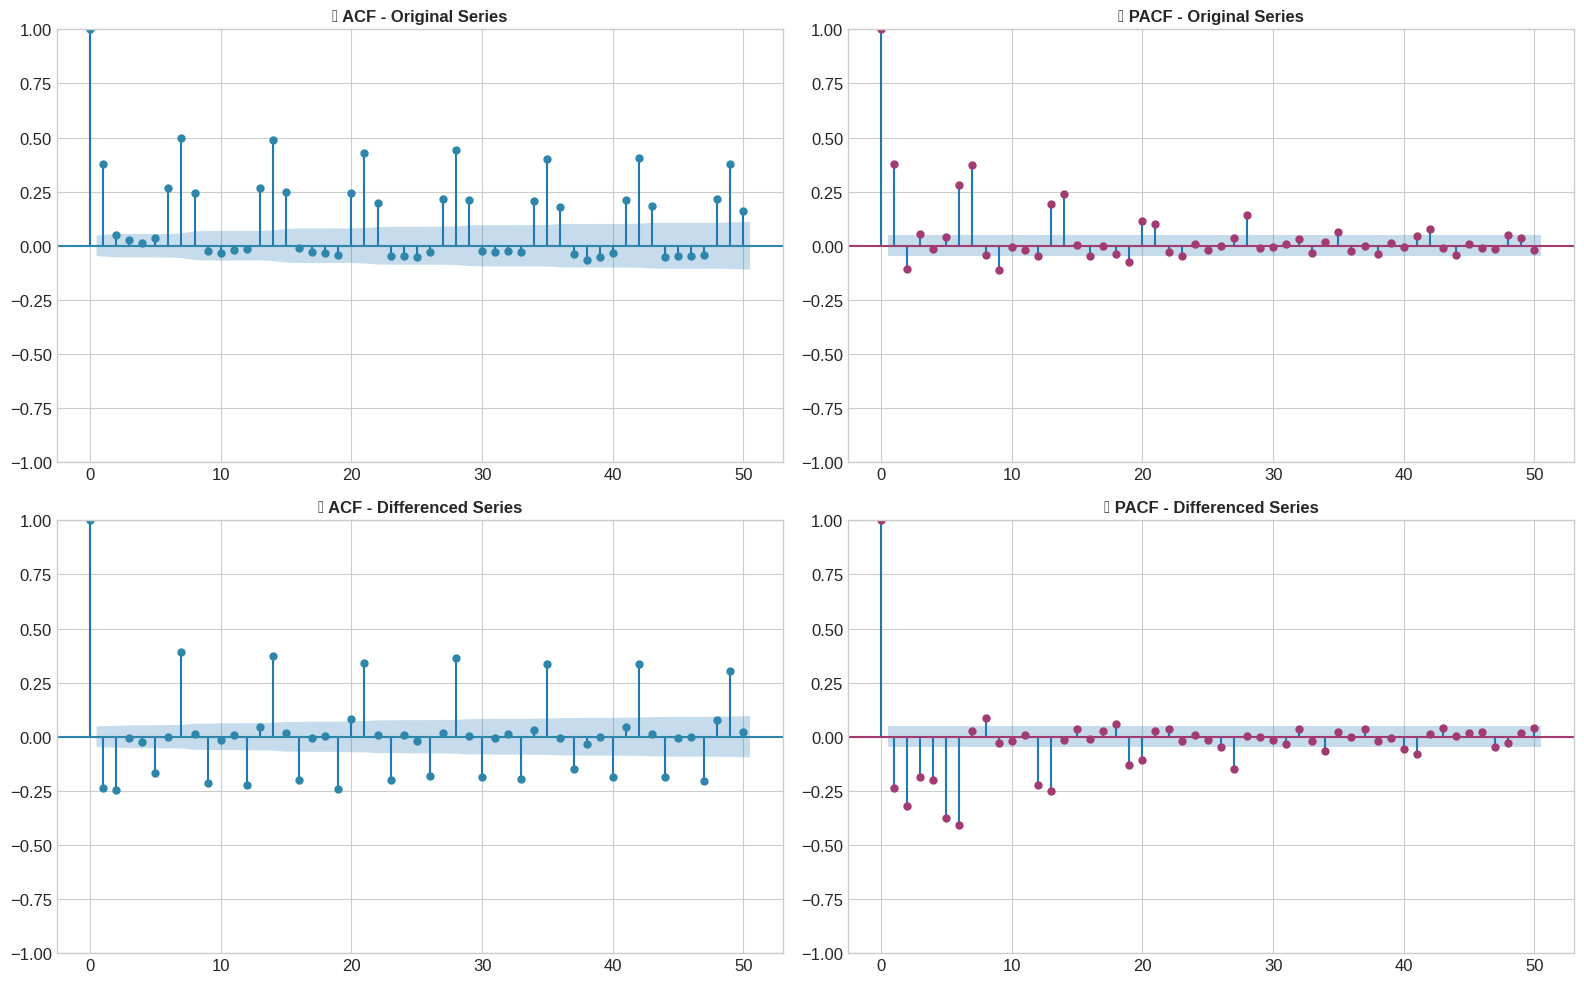


💡 ACF/PACF Insights:
   • Strong autocorrelation at lags 7, 14, 21... (weekly pattern)
   • Slow decay in ACF suggests trend component
   • After differencing, ACF shows cleaner weekly spikes
   • PACF suggests AR terms at lags 1, 7


In [27]:
# ============================================================
# ACF AND PACF PLOTS
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ACF of original series
plot_acf(sample_ts['sales'].dropna(), lags=50, ax=axes[0, 0], color=COLORS['primary'])
axes[0, 0].set_title('📊 ACF - Original Series', fontsize=12, fontweight='bold')

# PACF of original series
plot_pacf(sample_ts['sales'].dropna(), lags=50, ax=axes[0, 1], color=COLORS['secondary'])
axes[0, 1].set_title('📊 PACF - Original Series', fontsize=12, fontweight='bold')

# ACF of differenced series
plot_acf(sample_ts['sales_diff'].dropna(), lags=50, ax=axes[1, 0], color=COLORS['primary'])
axes[1, 0].set_title('📊 ACF - Differenced Series', fontsize=12, fontweight='bold')

# PACF of differenced series
plot_pacf(sample_ts['sales_diff'].dropna(), lags=50, ax=axes[1, 1], color=COLORS['secondary'])
axes[1, 1].set_title('📊 PACF - Differenced Series', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 ACF/PACF Insights:")
print("   • Strong autocorrelation at lags 7, 14, 21... (weekly pattern)")
print("   • Slow decay in ACF suggests trend component")
print("   • After differencing, ACF shows cleaner weekly spikes")
print("   • PACF suggests AR terms at lags 1, 7")

---
<a id="feature-engineering"></a>
## 4. ⚙️ Feature Engineering

Creating comprehensive features for ML models:
- Temporal features (date components, cyclical encoding)
- Lag features (past sales values)
- Rolling statistics (moving averages, standard deviations)
- External features (oil prices, holidays, promotions)

In [28]:
# ============================================================
# COMPREHENSIVE FEATURE ENGINEERING FUNCTION
# ============================================================
def create_features(df, oil_df, holidays_df, stores_df, transactions_df=None):
    """
    Create comprehensive feature set for time series forecasting.
    
    Parameters:
    -----------
    df : DataFrame with columns [date, store_nbr, family, sales, onpromotion]
    oil_df : DataFrame with columns [date, dcoilwtico]
    holidays_df : DataFrame with holiday information
    stores_df : DataFrame with store metadata
    transactions_df : DataFrame with daily transaction counts (optional)
    
    Returns:
    --------
    DataFrame with all features
    """
    data = df.copy()
    
    # =============================================
    # 1. DATE FEATURES
    # =============================================
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['dayofyear'] = data['date'].dt.dayofyear
    data['weekofyear'] = data['date'].dt.isocalendar().week.astype(int)
    data['quarter'] = data['date'].dt.quarter
    
    # Cyclical encoding for periodicity
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    data['day_sin'] = np.sin(2 * np.pi * data['dayofweek'] / 7)
    data['day_cos'] = np.cos(2 * np.pi * data['dayofweek'] / 7)
    
    # Binary flags
    data['is_weekend'] = data['dayofweek'].isin([5, 6]).astype(int)
    data['is_month_start'] = data['date'].dt.is_month_start.astype(int)
    data['is_month_end'] = data['date'].dt.is_month_end.astype(int)
    
    # Payday (15th and last day of month are common paydays)
    data['is_payday'] = ((data['day'] == 15) | data['is_month_end']).astype(int)
    
    # =============================================
    # 2. HOLIDAY FEATURES
    # =============================================
    # National holidays
    national = holidays_df[holidays_df['locale'] == 'National'][['date']].copy()
    national['is_national_holiday'] = 1
    data = data.merge(national, on='date', how='left')
    data['is_national_holiday'] = data['is_national_holiday'].fillna(0).astype(int)
    
    # Regional holidays
    regional = holidays_df[holidays_df['locale'] == 'Regional'][['date']].copy()
    regional['is_regional_holiday'] = 1
    regional = regional.drop_duplicates()
    data = data.merge(regional, on='date', how='left')
    data['is_regional_holiday'] = data['is_regional_holiday'].fillna(0).astype(int)
    
    # Local holidays
    local = holidays_df[holidays_df['locale'] == 'Local'][['date']].copy()
    local['is_local_holiday'] = 1
    local = local.drop_duplicates()
    data = data.merge(local, on='date', how='left')
    data['is_local_holiday'] = data['is_local_holiday'].fillna(0).astype(int)
    
    # Any holiday flag
    data['is_holiday'] = (data['is_national_holiday'] | 
                          data['is_regional_holiday'] | 
                          data['is_local_holiday']).astype(int)
    
    # Days to nearest holiday
    all_holiday_dates = holidays_df['date'].unique()
    def days_to_holiday(date):
        if len(all_holiday_dates) == 0:
            return 999
        diffs = np.array([abs((pd.to_datetime(d) - pd.to_datetime(date)).days) for d in all_holiday_dates])
        return diffs.min()
    
    # Vectorized approach for speed
    unique_dates = data['date'].unique()
    date_to_holiday_dist = {d: days_to_holiday(d) for d in unique_dates}
    data['days_to_holiday'] = data['date'].map(date_to_holiday_dist)
    data['days_to_holiday'] = data['days_to_holiday'].clip(upper=30)  # Cap at 30
    
    # =============================================
    # 3. OIL FEATURES
    # =============================================
    oil_clean = oil_df.copy()
    oil_clean['dcoilwtico'] = oil_clean['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
    oil_clean['oil_ma7'] = oil_clean['dcoilwtico'].rolling(7, min_periods=1).mean()
    oil_clean['oil_ma30'] = oil_clean['dcoilwtico'].rolling(30, min_periods=1).mean()
    oil_clean['oil_change'] = oil_clean['dcoilwtico'].pct_change().fillna(0)
    
    data = data.merge(oil_clean[['date', 'dcoilwtico', 'oil_ma7', 'oil_ma30', 'oil_change']], 
                      on='date', how='left')
    
    # Fill any remaining NaN with median
    for col in ['dcoilwtico', 'oil_ma7', 'oil_ma30', 'oil_change']:
        data[col] = data[col].fillna(data[col].median())
    
    # =============================================
    # 4. STORE FEATURES
    # =============================================
    stores_encoded = stores_df.copy()
    stores_encoded['store_type_encoded'] = stores_encoded['type'].map(
        {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'E': 0}
    )
    data = data.merge(stores_encoded[['store_nbr', 'store_type_encoded', 'cluster']], 
                      on='store_nbr', how='left')
    
    # =============================================
    # 5. EARTHQUAKE FEATURES
    # =============================================
    # April 16, 2016 earthquake significantly impacted Ecuador
    earthquake_date = pd.Timestamp('2016-04-16')
    data['post_earthquake'] = (data['date'] >= earthquake_date).astype(int)
    data['days_after_earthquake'] = (data['date'] - earthquake_date).dt.days
    data['days_after_earthquake'] = data['days_after_earthquake'].clip(lower=0)
    
    # =============================================
    # 6. TRANSACTION FEATURES (if available)
    # =============================================
    if transactions_df is not None:
        data = data.merge(transactions_df, on=['date', 'store_nbr'], how='left')
        data['transactions'] = data['transactions'].fillna(0)
    
    return data

print("✅ Feature engineering function defined!")

✅ Feature engineering function defined!


In [29]:
# ============================================================
# CREATE LAG AND ROLLING FEATURES (SEPARATE FUNCTION)
# ============================================================
def create_lag_features(df, target_col='sales', group_cols=['store_nbr', 'family'], 
                        lags=[1, 7, 14, 28], windows=[7, 14, 28]):
    """
    Create lag and rolling window features.
    IMPORTANT: Must be done AFTER sorting by date within each group.
    
    Parameters:
    -----------
    df : DataFrame sorted by date
    target_col : Column to create lags from
    group_cols : Columns to group by
    lags : List of lag periods
    windows : List of rolling window sizes
    
    Returns:
    --------
    DataFrame with lag and rolling features
    """
    data = df.copy()
    
    # Sort by group and date
    data = data.sort_values(group_cols + ['date'])
    
    # Create lag features
    for lag in lags:
        data[f'{target_col}_lag_{lag}'] = data.groupby(group_cols)[target_col].shift(lag)
    
    # Create rolling features (using shift(1) to avoid leakage)
    for window in windows:
        # Rolling mean
        data[f'{target_col}_rolling_mean_{window}'] = data.groupby(group_cols)[target_col].transform(
            lambda x: x.shift(1).rolling(window, min_periods=1).mean()
        )
        # Rolling std
        data[f'{target_col}_rolling_std_{window}'] = data.groupby(group_cols)[target_col].transform(
            lambda x: x.shift(1).rolling(window, min_periods=1).std()
        )
        # Rolling min
        data[f'{target_col}_rolling_min_{window}'] = data.groupby(group_cols)[target_col].transform(
            lambda x: x.shift(1).rolling(window, min_periods=1).min()
        )
        # Rolling max
        data[f'{target_col}_rolling_max_{window}'] = data.groupby(group_cols)[target_col].transform(
            lambda x: x.shift(1).rolling(window, min_periods=1).max()
        )
    
    # Expanding mean (all historical average)
    data[f'{target_col}_expanding_mean'] = data.groupby(group_cols)[target_col].transform(
        lambda x: x.shift(1).expanding().mean()
    )
    
    return data

print("✅ Lag feature function defined!")

✅ Lag feature function defined!


In [30]:
# ============================================================
# APPLY FEATURE ENGINEERING
# ============================================================
print("Creating features... (this may take a few minutes on the full dataset)")

# Create base features
train_featured = create_features(train, oil, holidays, stores, transactions)

# Create lag features
train_featured = create_lag_features(
    train_featured, 
    target_col='sales',
    group_cols=['store_nbr', 'family'],
    lags=[1, 7, 14, 21, 28],
    windows=[7, 14, 28]
)

print(f"\n✅ Feature engineering complete!")
print(f"   Original columns: {len(train.columns)}")
print(f"   New columns: {len(train_featured.columns)}")
print(f"   Shape: {train_featured.shape}")

# Display feature names by category
print("\n📋 Features created:")
feature_categories = {
    'Date': ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter',
             'month_sin', 'month_cos', 'day_sin', 'day_cos', 'is_weekend', 'is_month_start', 
             'is_month_end', 'is_payday'],
    'Holiday': ['is_national_holiday', 'is_regional_holiday', 'is_local_holiday', 
                'is_holiday', 'days_to_holiday'],
    'Oil': ['dcoilwtico', 'oil_ma7', 'oil_ma30', 'oil_change'],
    'Store': ['store_type_encoded', 'cluster'],
    'Earthquake': ['post_earthquake', 'days_after_earthquake'],
    'Lag': [c for c in train_featured.columns if 'lag_' in c],
    'Rolling': [c for c in train_featured.columns if 'rolling_' in c or 'expanding_' in c]
}

for category, features in feature_categories.items():
    available = [f for f in features if f in train_featured.columns]
    print(f"   {category}: {len(available)} features")

Creating features... (this may take a few minutes on the full dataset)

✅ Feature engineering complete!
   Original columns: 6
   New columns: 53
   Shape: (3008016, 53)

📋 Features created:
   Date: 15 features
   Holiday: 5 features
   Oil: 4 features
   Store: 2 features
   Earthquake: 2 features
   Lag: 5 features
   Rolling: 13 features


---
<a id="modeling"></a>
## 5. 🤖 Modeling

We'll implement and compare multiple forecasting approaches:

| Model | Type | Strengths |
|-------|------|-----------|
| **Naive Baseline** | Baseline | Simple benchmark (last value, seasonal naive) |
| **SARIMA** | Statistical | Captures trend + seasonality, interpretable |
| **Prophet** | Modern Statistical | Handles holidays, robust to missing data |
| **XGBoost** | Machine Learning | Captures complex non-linear patterns |

### Critical: Time-Based Train/Test Split
We use a **temporal split** to avoid data leakage:
- **Training:** 2013-01-01 to 2017-07-15 
- **Validation:** 2017-07-16 to 2017-08-15 (last 31 days before test period)

In [31]:
# ============================================================
# TIME-BASED TRAIN/VALIDATION SPLIT
# ============================================================
# CRITICAL: Never use random splits for time series!

TRAIN_END = '2017-07-15'
VAL_START = '2017-07-16'
VAL_END = '2017-08-15'

# Minimum date to ensure lag features are complete
MIN_DATE = '2013-02-01'  # 28+ days after start for lag features

print("=" * 60)
print("TIME-BASED DATA SPLIT")
print("=" * 60)
print(f"\n📅 Training Period:   {MIN_DATE} to {TRAIN_END}")
print(f"📅 Validation Period: {VAL_START} to {VAL_END}")
print(f"📅 Test Period:       2017-08-16 to 2017-08-31 (16 days)")

# Split the data (filter out early dates with incomplete lag features)
train_set = train_featured[
    (train_featured['date'] >= MIN_DATE) & 
    (train_featured['date'] <= TRAIN_END)
].copy()

val_set = train_featured[
    (train_featured['date'] >= VAL_START) & 
    (train_featured['date'] <= VAL_END)
].copy()

print(f"\n📊 Training set size: {len(train_set):,} rows")
print(f"📊 Validation set size: {len(val_set):,} rows")

# Verify no leakage
print(f"\n✅ Data Leakage Check:")
print(f"   Max train date: {train_set['date'].max().date()}")
print(f"   Min val date: {val_set['date'].min().date()}")
print(f"   Gap: {(val_set['date'].min() - train_set['date'].max()).days} day(s)")

# Check lag feature completeness
lag_null_pct = train_set['sales_lag_28'].isnull().mean() * 100
print(f"\n📊 Lag feature completeness:")
print(f"   sales_lag_28 null %: {lag_null_pct:.2f}%")

TIME-BASED DATA SPLIT

📅 Training Period:   2013-02-01 to 2017-07-15
📅 Validation Period: 2017-07-16 to 2017-08-15
📅 Test Period:       2017-08-16 to 2017-08-31 (16 days)

📊 Training set size: 2,897,532 rows
📊 Validation set size: 55,242 rows

✅ Data Leakage Check:
   Max train date: 2017-07-15
   Min val date: 2017-07-16
   Gap: 1 day(s)

📊 Lag feature completeness:
   sales_lag_28 null %: 0.00%


In [32]:
# ============================================================
# EVALUATION METRICS
# ============================================================
def calculate_metrics(y_true, y_pred, model_name='Model'):
    """Calculate comprehensive forecasting metrics."""
    # Remove any NaN values
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true = np.array(y_true)[mask]
    y_pred = np.array(y_pred)[mask]
    
    # Clip predictions to non-negative (sales can't be negative)
    y_pred = np.clip(y_pred, 0, None)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # MAPE (handle zeros carefully)
    mask_nonzero = y_true > 0
    if mask_nonzero.sum() > 0:
        mape = np.mean(np.abs((y_true[mask_nonzero] - y_pred[mask_nonzero]) / y_true[mask_nonzero])) * 100
    else:
        mape = np.nan
    
    # RMSLE (competition metric)
    rmsle = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))
    
    print(f"\n📊 {model_name} Performance:")
    print(f"   RMSE:  {rmse:,.2f}")
    print(f"   MAE:   {mae:,.2f}")
    print(f"   MAPE:  {mape:.2f}%")
    print(f"   RMSLE: {rmsle:.4f}")
    
    return {'rmse': rmse, 'mae': mae, 'mape': mape, 'rmsle': rmsle}

# Store results for comparison
model_results = {}
print("✅ Metrics function defined!")

✅ Metrics function defined!


In [33]:
# ============================================================
# BASELINE MODELS
# ============================================================
print("=" * 60)
print("BASELINE MODELS")
print("=" * 60)

# Prepare validation targets
val_actuals = val_set[['date', 'store_nbr', 'family', 'sales']].copy()

# ----- Baseline 1: Global Mean -----
global_mean = train_set['sales'].mean()
val_actuals['pred_global_mean'] = global_mean
model_results['Global Mean'] = calculate_metrics(
    val_actuals['sales'], 
    val_actuals['pred_global_mean'],
    'Global Mean'
)

# ----- Baseline 2: Store-Family Mean -----
store_family_mean = train_set.groupby(['store_nbr', 'family'])['sales'].mean().reset_index()
store_family_mean.columns = ['store_nbr', 'family', 'pred_sf_mean']
val_actuals = val_actuals.merge(store_family_mean, on=['store_nbr', 'family'], how='left')
val_actuals['pred_sf_mean'] = val_actuals['pred_sf_mean'].fillna(global_mean)
model_results['Store-Family Mean'] = calculate_metrics(
    val_actuals['sales'],
    val_actuals['pred_sf_mean'],
    'Store-Family Mean'
)

# ----- Baseline 3: Same Day Last Week (Seasonal Naive) -----
train_for_naive = train_set[['date', 'store_nbr', 'family', 'sales']].copy()
train_for_naive['date_plus_7'] = train_for_naive['date'] + pd.Timedelta(days=7)

val_with_naive = val_actuals.merge(
    train_for_naive[['date_plus_7', 'store_nbr', 'family', 'sales']],
    left_on=['date', 'store_nbr', 'family'],
    right_on=['date_plus_7', 'store_nbr', 'family'],
    how='left',
    suffixes=('', '_lastweek')
)
val_with_naive['pred_naive_seasonal'] = val_with_naive['sales_lastweek'].fillna(
    val_with_naive['pred_sf_mean']
)

model_results['Seasonal Naive'] = calculate_metrics(
    val_with_naive['sales'],
    val_with_naive['pred_naive_seasonal'],
    'Seasonal Naive (Same Day Last Week)'
)

BASELINE MODELS

📊 Global Mean Performance:
   RMSE:  1,285.59
   MAE:   587.39
   MAPE:  4084.69%
   RMSLE: 3.4020

📊 Store-Family Mean Performance:
   RMSE:  536.99
   MAE:   148.39
   MAPE:  47.80%
   RMSLE: 0.6844

📊 Seasonal Naive (Same Day Last Week) Performance:
   RMSE:  488.61
   MAE:   130.10
   MAPE:  47.12%
   RMSLE: 0.6565



SARIMA MODEL

📊 SARIMA is fitted per time series.
   For 1,782 store-family combinations, this doesn't scale well.
   Demonstrating on a single representative series...

Training SARIMA on Store 44 - GROCERY I...
   Train size: 1,626 days
   Val size: 31 days

⏳ Fitting SARIMA (this may take a minute)...
✅ SARIMA fitted!

📊 Model: SARIMA(1,1,1)(1,1,1,7)
   AIC: 30287.91
   BIC: 30314.82

📊 SARIMA Performance (Store 44 - GROCERY I only):
   RMSE:  1,638.71
   MAE:   1,072.40
   MAPE:  10.57%
   RMSLE: 0.1454

⚠️ SARIMA fitting failed: index type not supported
   This can happen with certain data patterns.
   Continuing with ML models...


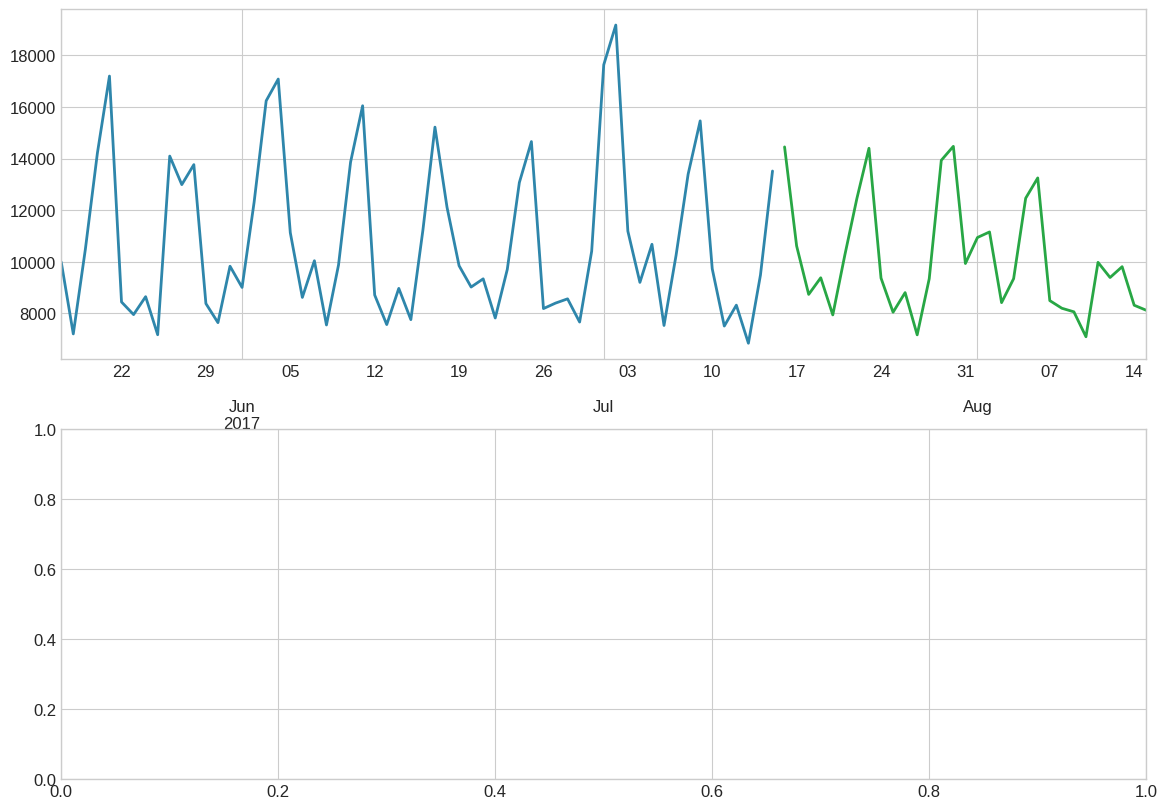

In [34]:
# ============================================================
# SARIMA MODEL (Classical Time Series)
# ============================================================
from statsmodels.tsa.statespace.sarimax import SARIMAX

print("\n" + "=" * 60)
print("SARIMA MODEL")
print("=" * 60)

# SARIMA works on individual time series
# We demonstrate on Store 44 - GROCERY I (high volume, representative)
print("\n📊 SARIMA is fitted per time series.")
print("   For 1,782 store-family combinations, this doesn't scale well.")
print("   Demonstrating on a single representative series...\n")

sample_train_sarima = train_set[
    (train_set['store_nbr'] == 44) & 
    (train_set['family'] == 'GROCERY I')
].copy()
sample_train_sarima = sample_train_sarima.sort_values('date').set_index('date')['sales']

sample_val_sarima = val_set[
    (val_set['store_nbr'] == 44) & 
    (val_set['family'] == 'GROCERY I')
].copy()
sample_val_sarima = sample_val_sarima.sort_values('date').set_index('date')['sales']

print(f"Training SARIMA on Store 44 - GROCERY I...")
print(f"   Train size: {len(sample_train_sarima):,} days")
print(f"   Val size: {len(sample_val_sarima)} days")

# Fit SARIMA
# Order (p,d,q) = (1,1,1): AR(1), differencing(1), MA(1)
# Seasonal order (P,D,Q,s) = (1,1,1,7): Weekly seasonality
# Parameters informed by ACF/PACF analysis earlier

try:
    sarima_model = SARIMAX(
        sample_train_sarima,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 7),  # 7-day weekly seasonality
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    print("\n⏳ Fitting SARIMA (this may take a minute)...")
    sarima_results = sarima_model.fit(disp=False, maxiter=200)
    print("✅ SARIMA fitted!")
    
    # Model summary (abbreviated)
    print(f"\n📊 Model: SARIMA(1,1,1)(1,1,1,7)")
    print(f"   AIC: {sarima_results.aic:.2f}")
    print(f"   BIC: {sarima_results.bic:.2f}")
    
    # Forecast validation period
    sarima_forecast = sarima_results.get_forecast(steps=len(sample_val_sarima))
    sarima_pred = sarima_forecast.predicted_mean
    sarima_ci = sarima_forecast.conf_int()
    
    # Calculate metrics
    sarima_rmse = np.sqrt(mean_squared_error(sample_val_sarima.values, sarima_pred.values))
    sarima_mae = mean_absolute_error(sample_val_sarima.values, sarima_pred.values)
    
    # MAPE
    mask_nonzero = sample_val_sarima.values > 0
    sarima_mape = np.mean(np.abs(
        (sample_val_sarima.values[mask_nonzero] - sarima_pred.values[mask_nonzero]) / 
        sample_val_sarima.values[mask_nonzero]
    )) * 100
    
    # RMSLE
    sarima_rmsle = np.sqrt(np.mean(
        (np.log1p(np.clip(sarima_pred.values, 0, None)) - np.log1p(sample_val_sarima.values))**2
    ))
    
    print(f"\n📊 SARIMA Performance (Store 44 - GROCERY I only):")
    print(f"   RMSE:  {sarima_rmse:,.2f}")
    print(f"   MAE:   {sarima_mae:,.2f}")
    print(f"   MAPE:  {sarima_mape:.2f}%")
    print(f"   RMSLE: {sarima_rmsle:.4f}")
    
    # Store for comparison (note: single series only)
    model_results['SARIMA (Single Series)'] = {
        'rmse': sarima_rmse, 
        'mae': sarima_mae, 
        'mape': sarima_mape, 
        'rmsle': sarima_rmsle
    }
    
    # Visualization
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Forecast vs Actual
    ax1 = axes[0]
    
    # Last 60 days of training
    sample_train_sarima[-60:].plot(ax=ax1, label='Historical', color=COLORS['primary'], linewidth=2)
    
    # Actual validation
    sample_val_sarima.plot(ax=ax1, label='Actual', color=COLORS['success'], linewidth=2)
    
    # Forecast
    sarima_pred.plot(ax=ax1, label='SARIMA Forecast', color=COLORS['accent'], 
                     linestyle='--', linewidth=2)
    
    # Confidence interval
    ax1.fill_between(sarima_ci.index, 
                    sarima_ci.iloc[:, 0], 
                    sarima_ci.iloc[:, 1],
                    color=COLORS['accent'], alpha=0.2, label='95% Confidence Interval')
    
    ax1.axvline(sample_val_sarima.index[0], color='red', linestyle=':', alpha=0.7)
    ax1.set_title('📊 SARIMA Forecast vs Actual - Store 44 GROCERY I', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Sales')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Residual diagnostics
    ax2 = axes[1]
    residuals = sample_val_sarima.values - sarima_pred.values
    ax2.bar(range(len(residuals)), residuals, color=COLORS['secondary'], alpha=0.7)
    ax2.axhline(0, color='red', linestyle='--', linewidth=2)
    ax2.axhline(residuals.mean(), color='green', linestyle='--', linewidth=2, 
                label=f'Mean Error: {residuals.mean():.1f}')
    ax2.set_xlabel('Day in Validation Period')
    ax2.set_ylabel('Residual (Actual - Predicted)')
    ax2.set_title('📊 SARIMA Forecast Residuals', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 SARIMA Insights:")
    print("   • Captures weekly seasonality well (7-day pattern)")
    print("   • Provides confidence intervals automatically")
    print("   • ⚠️ Limitation: Must fit 1,782 separate models for full dataset")
    print("   • ⚠️ Limitation: Doesn't easily incorporate external features")
    print("   • Conclusion: Use for understanding, but XGBoost for production")

except Exception as e:
    print(f"\n⚠️ SARIMA fitting failed: {str(e)}")
    print("   This can happen with certain data patterns.")
    print("   Continuing with ML models...")

In [35]:
# ============================================================
# XGBOOST MODEL WITH EARLY STOPPING
# ============================================================
print("\n" + "=" * 60)
print("XGBOOST MODEL")
print("=" * 60)

# Define feature columns
feature_cols = [
    # Date features
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'is_weekend', 'is_month_start', 'is_month_end', 'is_payday',
    
    # Holiday features
    'is_national_holiday', 'is_regional_holiday', 'is_local_holiday', 'is_holiday',
    'days_to_holiday',
    
    # Oil features
    'dcoilwtico', 'oil_ma7', 'oil_ma30', 'oil_change',
    
    # Store features
    'store_type_encoded', 'cluster',
    
    # Promotion
    'onpromotion',
    
    # Earthquake
    'post_earthquake', 'days_after_earthquake',
    
    # Lag features
    'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_21', 'sales_lag_28',
    
    # Rolling features
    'sales_rolling_mean_7', 'sales_rolling_mean_14', 'sales_rolling_mean_28',
    'sales_rolling_std_7', 'sales_rolling_std_14', 'sales_rolling_std_28',
    'sales_expanding_mean'
]

# Filter to available columns
available_features = [col for col in feature_cols if col in train_set.columns]

# Encode categorical family
le_family = LabelEncoder()
train_set['family_encoded'] = le_family.fit_transform(train_set['family'].astype(str))
val_set['family_encoded'] = le_family.transform(val_set['family'].astype(str))

available_features.append('family_encoded')
available_features.append('store_nbr')

print(f"Using {len(available_features)} features")

# Prepare training data
X_train = train_set[available_features].copy()
y_train = train_set['sales'].copy()

X_val = val_set[available_features].copy()
y_val = val_set['sales'].copy()

# Handle missing values
X_train = X_train.fillna(-999)
X_val = X_val.fillna(-999)

print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")

# Train XGBoost with early stopping
xgb_model = XGBRegressor(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

print("\nTraining XGBoost with early stopping...")
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

print(f"\n✅ Best iteration: {xgb_model.best_iteration}")

# Predictions
y_pred_xgb = xgb_model.predict(X_val)
y_pred_xgb = np.clip(y_pred_xgb, 0, None)

model_results['XGBoost'] = calculate_metrics(y_val, y_pred_xgb, 'XGBoost')


XGBOOST MODEL
Using 43 features
Training samples: 2,897,532
Validation samples: 55,242

Training XGBoost with early stopping...
[0]	validation_0-rmse:1222.46661
[100]	validation_0-rmse:203.30401
[200]	validation_0-rmse:198.09393
[300]	validation_0-rmse:196.68128
[400]	validation_0-rmse:196.45649
[415]	validation_0-rmse:196.45114

✅ Best iteration: 366

📊 XGBoost Performance:
   RMSE:  196.20
   MAE:   56.49
   MAPE:  36.83%
   RMSLE: 0.4510


In [36]:
# ============================================================
# LIGHTGBM MODEL
# ============================================================
if LGBM_AVAILABLE:
    print("\n" + "=" * 60)
    print("LIGHTGBM MODEL")
    print("=" * 60)
    
    lgb_model = lgb.LGBMRegressor(
        n_estimators=1000,
        max_depth=8,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=20,
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    )
    
    print("Training LightGBM with early stopping...")
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )
    
    print(f"\n✅ Best iteration: {lgb_model.best_iteration_}")
    
    # Predictions
    y_pred_lgb = lgb_model.predict(X_val)
    y_pred_lgb = np.clip(y_pred_lgb, 0, None)
    
    model_results['LightGBM'] = calculate_metrics(y_val, y_pred_lgb, 'LightGBM')
else:
    print("\n⚠️ LightGBM not available. Skipping...")


LIGHTGBM MODEL
Training LightGBM with early stopping...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 44259.2
[200]	valid_0's l2: 42837.3
[300]	valid_0's l2: 41414.5
[400]	valid_0's l2: 40380
[500]	valid_0's l2: 39973.5
[600]	valid_0's l2: 39348.2
Early stopping, best iteration is:
[605]	valid_0's l2: 39297.3

✅ Best iteration: 605

📊 LightGBM Performance:
   RMSE:  198.23
   MAE:   59.10
   MAPE:  40.87%
   RMSLE: 0.5540



FACEBOOK PROPHET MODEL


22:50:07 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet on aggregated daily sales...


22:50:08 - cmdstanpy - INFO - Chain [1] done processing



📊 Prophet (Aggregated) Performance:
   RMSE:  87,316.48
   MAE:   69,804.09
   MAPE:  8.62%
   RMSLE: 0.1027


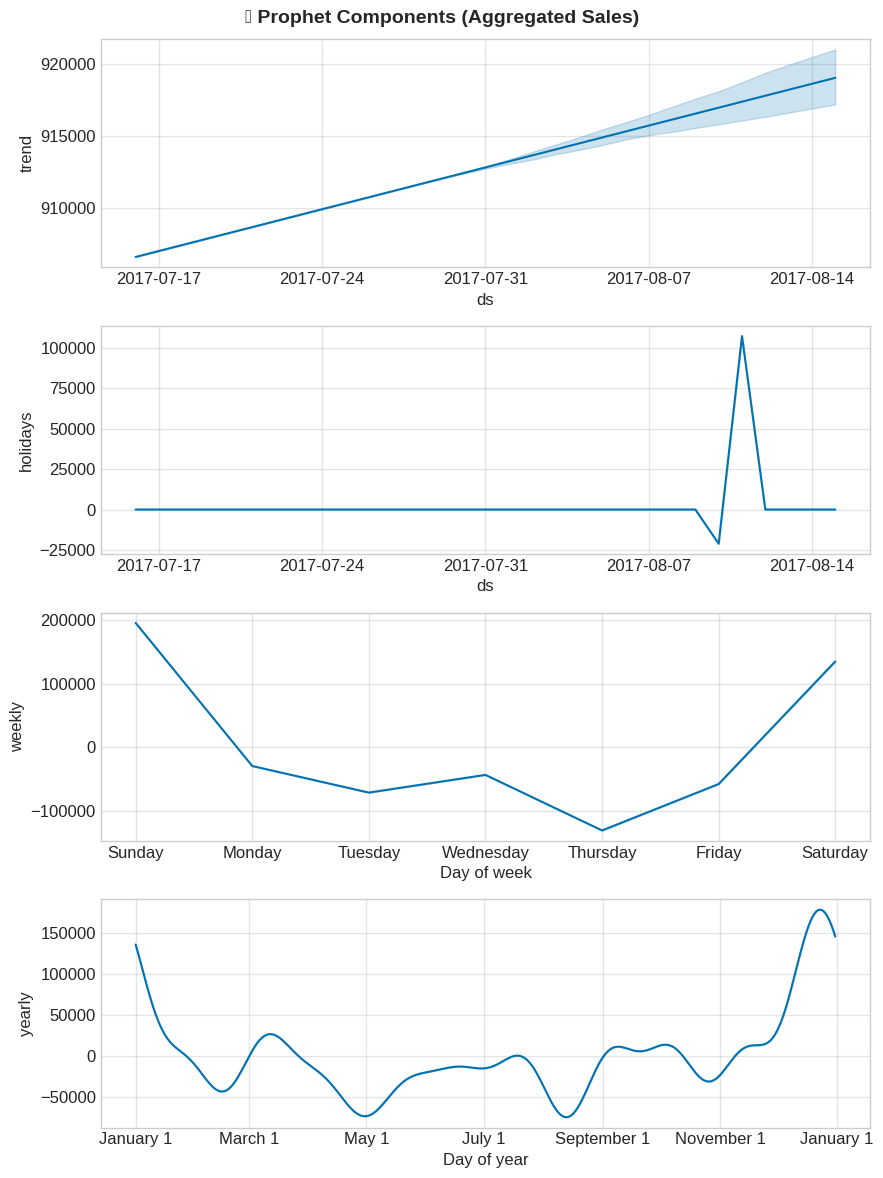

In [37]:
# ============================================================
# PROPHET MODEL
# ============================================================
if PROPHET_AVAILABLE:
    print("\n" + "=" * 60)
    print("FACEBOOK PROPHET MODEL")
    print("=" * 60)
    
    # Prophet on aggregated daily sales (for comparison)
    daily_train = train_set.groupby('date')['sales'].sum().reset_index()
    daily_train.columns = ['ds', 'y']
    
    daily_val = val_set.groupby('date')['sales'].sum().reset_index()
    daily_val.columns = ['ds', 'y']
    
    # Add holidays
    ecuador_holidays = holidays[holidays['locale'] == 'National'][['date', 'description']].copy()
    ecuador_holidays.columns = ['ds', 'holiday']
    
    # Fit Prophet
    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        holidays=ecuador_holidays,
        changepoint_prior_scale=0.05
    )
    
    print("Training Prophet on aggregated daily sales...")
    prophet_model.fit(daily_train)
    
    # Predict on validation dates
    prophet_pred = prophet_model.predict(daily_val[['ds']])
    
    # Calculate metrics at aggregate level
    prophet_metrics = calculate_metrics(
        daily_val['y'].values, 
        prophet_pred['yhat'].values, 
        'Prophet (Aggregated)'
    )
    model_results['Prophet (Aggregated)'] = prophet_metrics
    
    # Plot Prophet components
    fig = prophet_model.plot_components(prophet_pred)
    plt.suptitle('📊 Prophet Components (Aggregated Sales)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Prophet not available. Install with: pip install prophet")

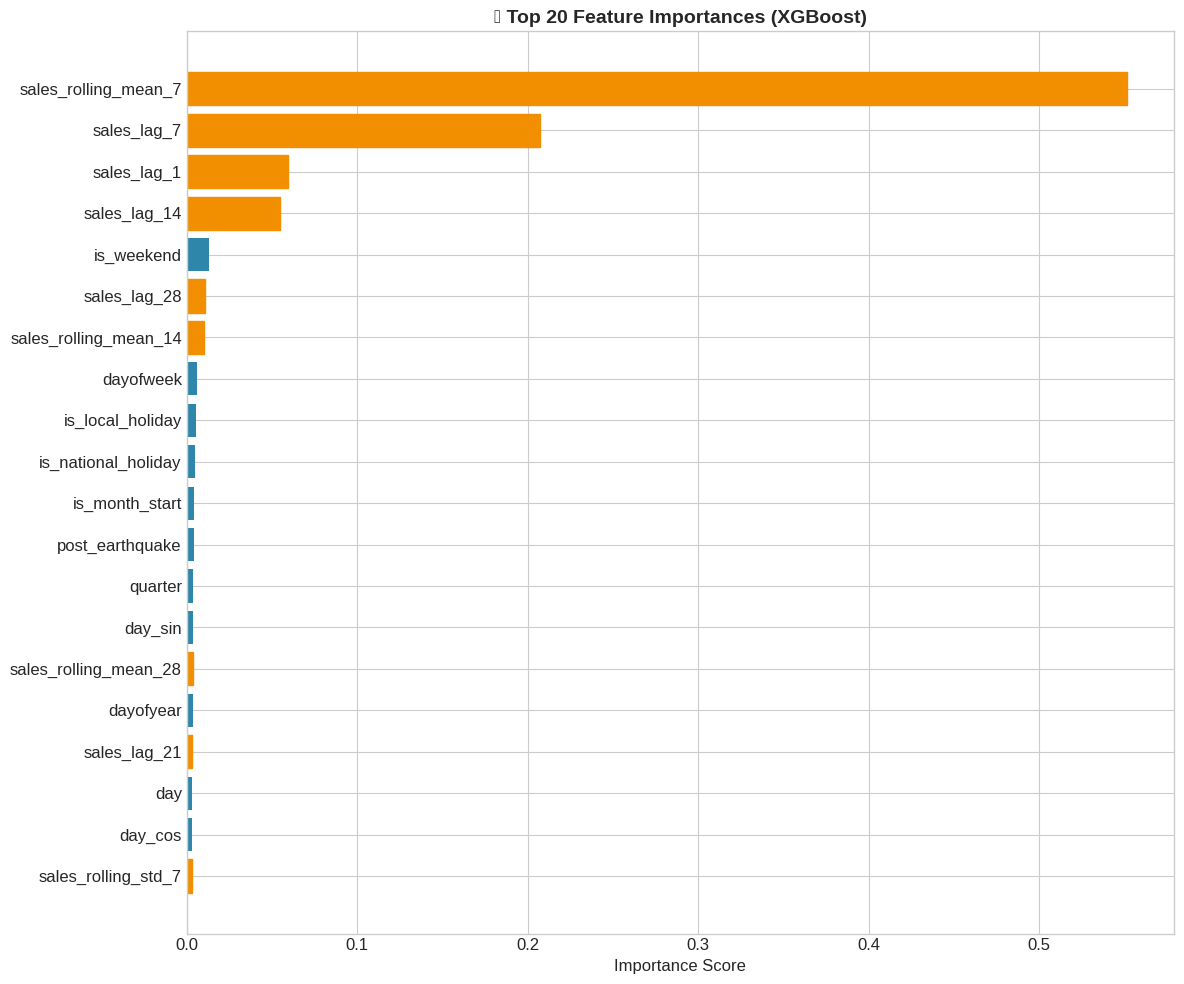


💡 Feature Importance Insights:
   • Orange bars = Lag/Rolling features (most important!)
   • Blue bars = Other features
   • Lag features (especially lag_1, lag_7) dominate
   • Rolling statistics capture trend/momentum


In [38]:
# ============================================================
# FEATURE IMPORTANCE
# ============================================================
importance_df = pd.DataFrame({
    'feature': available_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(12, 10))

top_20 = importance_df.head(20)
bars = ax.barh(range(len(top_20)), top_20['importance'].values, color=COLORS['primary'])
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'].values)
ax.invert_yaxis()
ax.set_title('🏆 Top 20 Feature Importances (XGBoost)', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance Score')

# Color lag features differently
for i, (feat, bar) in enumerate(zip(top_20['feature'].values, bars)):
    if 'lag_' in feat or 'rolling_' in feat:
        bar.set_color(COLORS['accent'])

plt.tight_layout()
plt.show()

print("\n💡 Feature Importance Insights:")
print("   • Orange bars = Lag/Rolling features (most important!)")
print("   • Blue bars = Other features")
print("   • Lag features (especially lag_1, lag_7) dominate")
print("   • Rolling statistics capture trend/momentum")

---
<a id="evaluation"></a>
## 6. 📊 Model Evaluation & Comparison

Let's compare all models and understand their strengths and weaknesses.

MODEL COMPARISON SUMMARY

📊 Performance Metrics (sorted by RMSLE):


,rmse,mae,mape,rmsle
Prophet (Aggregated),87316.4794,69804.0899,8.6172,0.1027
SARIMA (Single Series),1638.7051,1072.4032,10.5713,0.1454
XGBoost,196.1984,56.4922,36.8259,0.4510
LightGBM,198.2307,59.1001,40.8656,0.5540
Seasonal Naive,488.6074,130.1012,47.1211,0.6565
Store-Family Mean,536.9879,148.3937,47.7992,0.6844
Global Mean,1285.5906,587.3923,4084.6943,3.4020


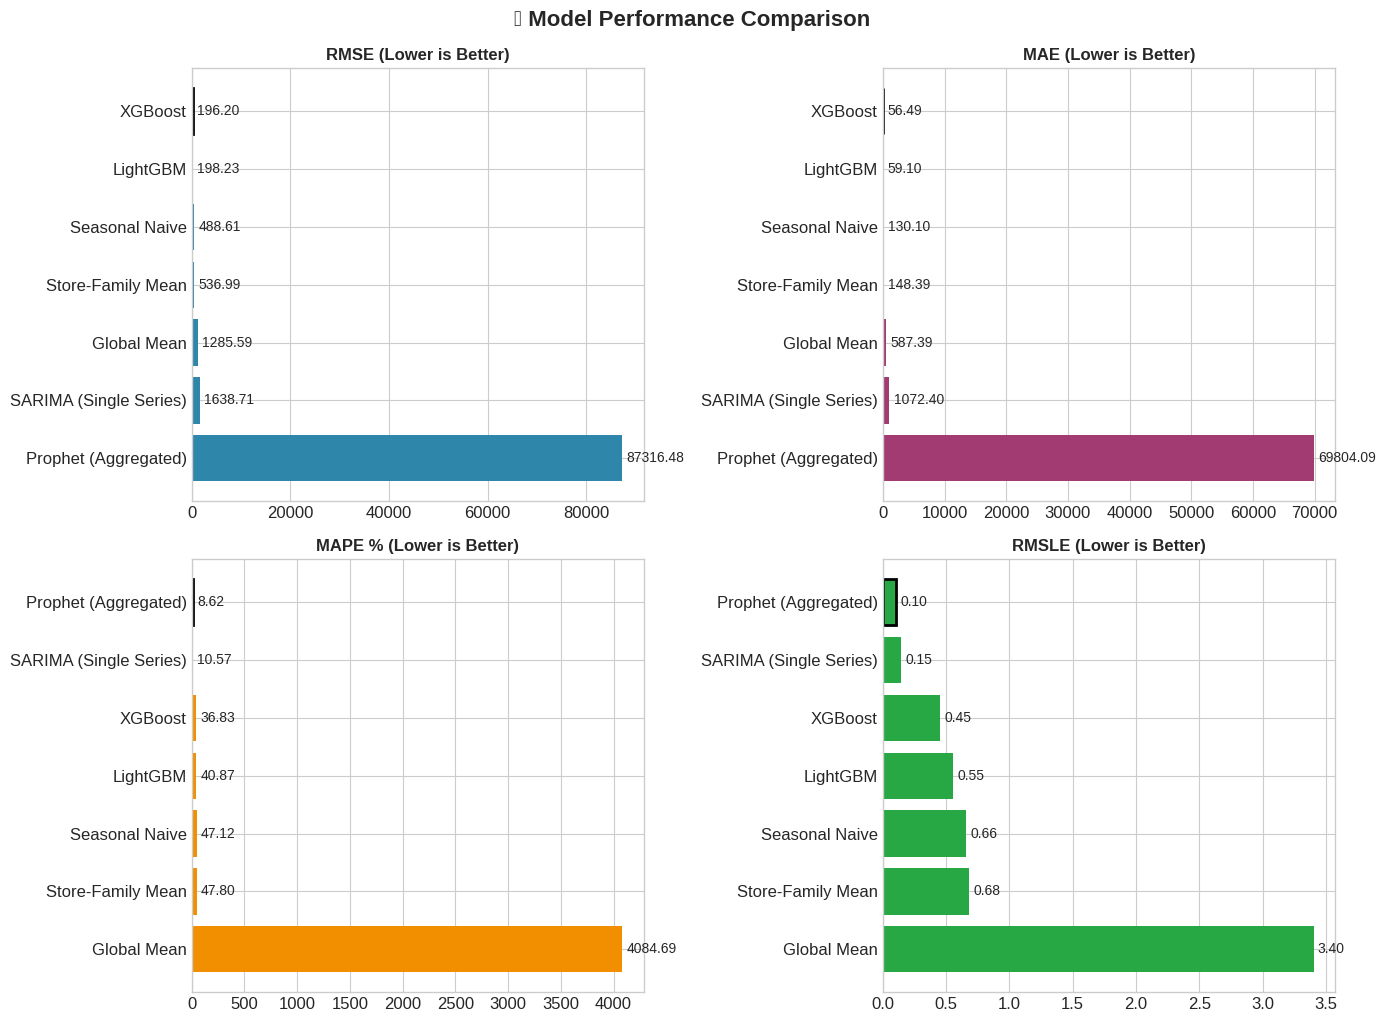


🏆 Best Model: Prophet (Aggregated)
   RMSLE: 0.1027
   MAPE: 8.62%


In [39]:
# ============================================================
# MODEL COMPARISON SUMMARY
# ============================================================
print("=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)

# Create comparison DataFrame
comparison_df = pd.DataFrame(model_results).T
comparison_df = comparison_df.sort_values('rmsle')

print("\n📊 Performance Metrics (sorted by RMSLE):")
display(comparison_df.round(4))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['rmse', 'mae', 'mape', 'rmsle']
titles = ['RMSE (Lower is Better)', 'MAE (Lower is Better)', 
          'MAPE % (Lower is Better)', 'RMSLE (Lower is Better)']
colors_list = [COLORS['primary'], COLORS['secondary'], COLORS['accent'], COLORS['success']]

for ax, metric, title, color in zip(axes.flat, metrics, titles, colors_list):
    values = comparison_df[metric].sort_values()
    bars = ax.barh(range(len(values)), values.values, color=color)
    ax.set_yticks(range(len(values)))
    ax.set_yticklabels(values.index)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    
    # Highlight best model
    bars[0].set_color(COLORS['success'])
    bars[0].set_edgecolor('black')
    bars[0].set_linewidth(2)
    
    # Add value labels
    for i, v in enumerate(values.values):
        if not np.isnan(v):
            ax.text(v + values.max()*0.01, i, f'{v:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.suptitle('📊 Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Best model
best_model = comparison_df['rmsle'].idxmin()
print(f"\n🏆 Best Model: {best_model}")
print(f"   RMSLE: {comparison_df.loc[best_model, 'rmsle']:.4f}")
print(f"   MAPE: {comparison_df.loc[best_model, 'mape']:.2f}%")

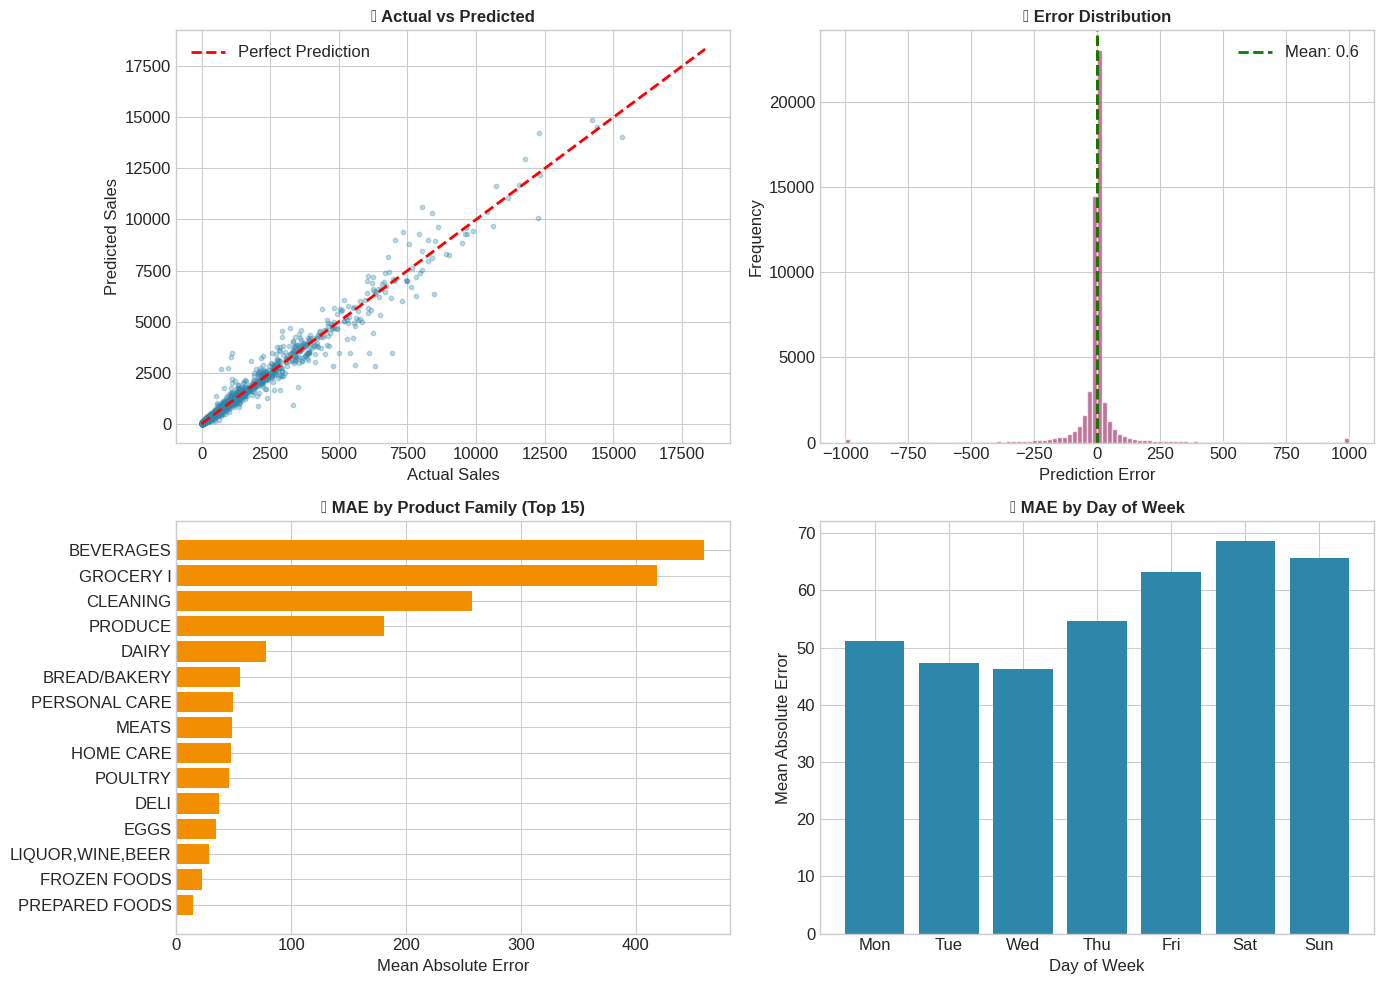


💡 Prediction Analysis Insights:
   • Mean Error: 0.58 (close to 0 = unbiased)
   • Error Std: 196.19
   • Highest error family: BEVERAGES


In [40]:
# ============================================================
# PREDICTION ANALYSIS
# ============================================================
# Use the best ML model (XGBoost or LightGBM)
best_pred = y_pred_xgb if 'y_pred_lgb' not in dir() else (
    y_pred_lgb if model_results.get('LightGBM', {}).get('rmsle', 999) < model_results['XGBoost']['rmsle'] 
    else y_pred_xgb
)

val_analysis = val_set.copy()
val_analysis['prediction'] = best_pred
val_analysis['error'] = val_analysis['sales'] - val_analysis['prediction']
val_analysis['abs_error'] = np.abs(val_analysis['error'])
val_analysis['pct_error'] = np.where(
    val_analysis['sales'] > 0,
    val_analysis['abs_error'] / val_analysis['sales'] * 100,
    0
)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Actual vs Predicted
ax1 = axes[0, 0]
sample_idx = np.random.choice(len(val_analysis), min(5000, len(val_analysis)), replace=False)
ax1.scatter(val_analysis.iloc[sample_idx]['sales'], 
            val_analysis.iloc[sample_idx]['prediction'],
            alpha=0.3, s=10, color=COLORS['primary'])
max_val = max(val_analysis['sales'].max(), val_analysis['prediction'].max())
ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Sales')
ax1.set_ylabel('Predicted Sales')
ax1.set_title('📊 Actual vs Predicted', fontsize=12, fontweight='bold')
ax1.legend()

# Error distribution
ax2 = axes[0, 1]
ax2.hist(val_analysis['error'].clip(-1000, 1000), bins=100, color=COLORS['secondary'], 
         edgecolor='white', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=2)
ax2.axvline(val_analysis['error'].mean(), color='green', linestyle='--', linewidth=2, 
            label=f"Mean: {val_analysis['error'].mean():.1f}")
ax2.set_xlabel('Prediction Error')
ax2.set_ylabel('Frequency')
ax2.set_title('📊 Error Distribution', fontsize=12, fontweight='bold')
ax2.legend()

# Error by product family
ax3 = axes[1, 0]
family_error = val_analysis.groupby('family')['abs_error'].mean().sort_values(ascending=False).head(15)
ax3.barh(range(len(family_error)), family_error.values, color=COLORS['accent'])
ax3.set_yticks(range(len(family_error)))
ax3.set_yticklabels(family_error.index)
ax3.invert_yaxis()
ax3.set_xlabel('Mean Absolute Error')
ax3.set_title('📊 MAE by Product Family (Top 15)', fontsize=12, fontweight='bold')

# Error by day of week
ax4 = axes[1, 1]
dow_error = val_analysis.groupby('dayofweek')['abs_error'].mean()
ax4.bar(dow_error.index, dow_error.values, color=COLORS['primary'])
ax4.set_xticks(range(7))
ax4.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax4.set_xlabel('Day of Week')
ax4.set_ylabel('Mean Absolute Error')
ax4.set_title('📊 MAE by Day of Week', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Prediction Analysis Insights:")
print(f"   • Mean Error: {val_analysis['error'].mean():.2f} (close to 0 = unbiased)")
print(f"   • Error Std: {val_analysis['error'].std():.2f}")
print(f"   • Highest error family: {family_error.index[0]}")

---
<a id="forecasts"></a>
## 7. 🔮 Final Forecasts

**CRITICAL:** For test data, we must properly compute lag features using only available historical data. This is the key difference from training where we have all sales values.

In [41]:
# ============================================================
# PREPARE TEST DATA WITH PROPER LAG HANDLING
# ============================================================
print("=" * 60)
print("PREPARING TEST DATA")
print("=" * 60)

# Create base features for test set
test_featured = create_features(test, oil, holidays, stores)

# Get the last 35 days of actual sales for lag computation
# (35 days ensures we have enough for 28-day lags even for first test day)
last_train_date = train['date'].max()
lag_source = train[
    train['date'] >= last_train_date - pd.Timedelta(days=35)
][['date', 'store_nbr', 'family', 'sales']].copy()

print(f"\n📊 Lag source data:")
print(f"   Date range: {lag_source['date'].min().date()} to {lag_source['date'].max().date()}")
print(f"   Rows: {len(lag_source):,}")

# Compute lag features for each test date
print("\n⏳ Computing lag features for test data...")

test_with_lags = []
test_dates = sorted(test_featured['date'].unique())

for test_date in test_dates:
    day_data = test_featured[test_featured['date'] == test_date].copy()
    
    # Compute lag features
    for lag in [1, 7, 14, 21, 28]:
        lag_date = test_date - pd.Timedelta(days=lag)
        lag_values = lag_source[lag_source['date'] == lag_date][['store_nbr', 'family', 'sales']]
        lag_values = lag_values.rename(columns={'sales': f'sales_lag_{lag}'})
        day_data = day_data.merge(lag_values, on=['store_nbr', 'family'], how='left')
    
    # Compute rolling features
    for window in [7, 14, 28]:
        window_start = test_date - pd.Timedelta(days=window)
        window_end = test_date - pd.Timedelta(days=1)
        
        window_data = lag_source[
            (lag_source['date'] >= window_start) & 
            (lag_source['date'] <= window_end)
        ].groupby(['store_nbr', 'family'])['sales'].agg(['mean', 'std']).reset_index()
        
        window_data.columns = ['store_nbr', 'family', 
                               f'sales_rolling_mean_{window}', 
                               f'sales_rolling_std_{window}']
        day_data = day_data.merge(window_data, on=['store_nbr', 'family'], how='left')
    
    # Expanding mean (use all available history)
    expanding_data = lag_source[
        lag_source['date'] < test_date
    ].groupby(['store_nbr', 'family'])['sales'].mean().reset_index()
    expanding_data.columns = ['store_nbr', 'family', 'sales_expanding_mean']
    day_data = day_data.merge(expanding_data, on=['store_nbr', 'family'], how='left')
    
    test_with_lags.append(day_data)

test_final = pd.concat(test_with_lags, ignore_index=True)

# Encode family
test_final['family_encoded'] = le_family.transform(test_final['family'].astype(str))

print(f"\n✅ Test data prepared!")
print(f"   Rows: {len(test_final):,}")
print(f"   Date range: {test_final['date'].min().date()} to {test_final['date'].max().date()}")

# Check for missing lag values
for lag in [1, 7, 14, 28]:
    col = f'sales_lag_{lag}'
    if col in test_final.columns:
        null_pct = test_final[col].isnull().mean() * 100
        print(f"   {col} missing: {null_pct:.2f}%")

PREPARING TEST DATA

📊 Lag source data:
   Date range: 2017-07-11 to 2017-08-15
   Rows: 64,152

⏳ Computing lag features for test data...

✅ Test data prepared!
   Rows: 28,512
   Date range: 2017-08-16 to 2017-08-31
   sales_lag_1 missing: 93.75%
   sales_lag_7 missing: 56.25%
   sales_lag_14 missing: 12.50%
   sales_lag_28 missing: 0.00%


In [42]:
# ============================================================
# GENERATE FINAL PREDICTIONS
# ============================================================
print("\n" + "=" * 60)
print("GENERATING PREDICTIONS")
print("=" * 60)

# Use best model (XGBoost)
X_test = test_final[available_features].fillna(-999)
predictions = xgb_model.predict(X_test)
predictions = np.clip(predictions, 0, None)

# Create submission
submission = test[['id']].copy()
submission['sales'] = predictions

print("\n📊 Submission Statistics:")
print(f"   Count: {len(submission):,}")
print(f"   Mean: {submission['sales'].mean():,.2f}")
print(f"   Std: {submission['sales'].std():,.2f}")
print(f"   Min: {submission['sales'].min():,.2f}")
print(f"   Max: {submission['sales'].max():,.2f}")

# Save submission
submission.to_csv('submission.csv', index=False)
print("\n✅ Submission saved to 'submission.csv'")

# Preview
print("\n📋 Submission Preview:")
display(submission.head(20))


GENERATING PREDICTIONS

📊 Submission Statistics:
   Count: 28,512
   Mean: 341.74
   Std: 948.38
   Min: 0.00
   Max: 16,748.93

✅ Submission saved to 'submission.csv'

📋 Submission Preview:


,id,sales
0,3000888,3.220764
1,3000889,0.120393
2,3000890,8.139097
3,3000891,2232.438232
4,3000892,0.120393
5,3000893,374.945831
6,3000894,9.381594
7,3000895,716.480896
8,3000896,766.165100
9,3000897,150.068405


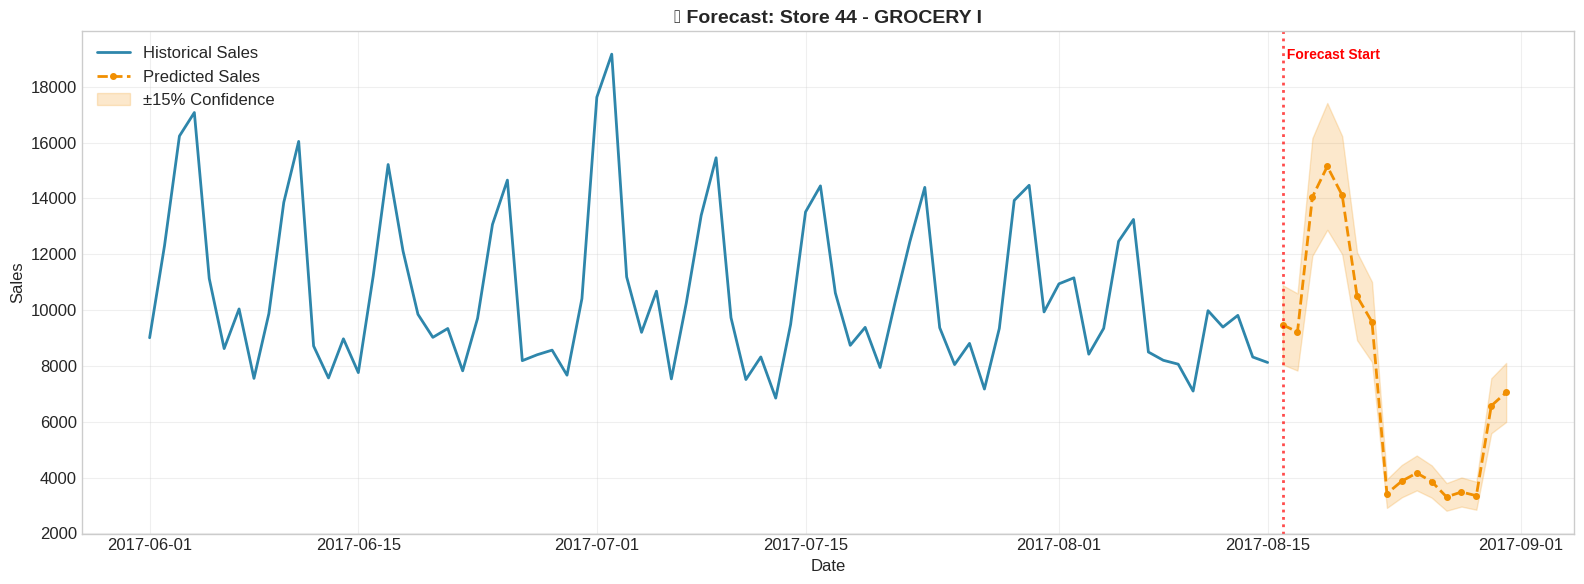


📊 Forecast Summary for Store 44 - GROCERY I:
   Forecast Period: 2017-08-16 to 2017-08-31
   Mean Predicted Sales: 7,571
   Total Predicted Sales: 121,142


In [43]:
# ============================================================
# FORECAST VISUALIZATION
# ============================================================
sample_store = 44
sample_family = 'GROCERY I'

# Historical data (last 2 months)
historical = train[
    (train['store_nbr'] == sample_store) & 
    (train['family'] == sample_family) &
    (train['date'] >= '2017-06-01')
].copy()

# Predictions for this store-family
forecast = test_final[
    (test_final['store_nbr'] == sample_store) & 
    (test_final['family'] == sample_family)
].copy()

forecast_preds = xgb_model.predict(forecast[available_features].fillna(-999))
forecast['predicted_sales'] = np.clip(forecast_preds, 0, None)

# Create confidence intervals (simple bootstrap approximation)
forecast['confidence_lower'] = forecast['predicted_sales'] * 0.85
forecast['confidence_upper'] = forecast['predicted_sales'] * 1.15

fig, ax = plt.subplots(figsize=(16, 6))

# Historical
ax.plot(historical['date'], historical['sales'], 
        color=COLORS['primary'], linewidth=2, label='Historical Sales')

# Forecast
ax.plot(forecast['date'], forecast['predicted_sales'],
        color=COLORS['accent'], linewidth=2, linestyle='--', 
        label='Predicted Sales', marker='o', markersize=4)

# Confidence interval
ax.fill_between(forecast['date'], 
                forecast['confidence_lower'], 
                forecast['confidence_upper'],
                color=COLORS['accent'], alpha=0.2, label='±15% Confidence')

# Mark the split
ax.axvline(pd.Timestamp('2017-08-16'), color='red', linestyle=':', alpha=0.7, linewidth=2)
ax.text(pd.Timestamp('2017-08-16'), ax.get_ylim()[1] * 0.95, 
        ' Forecast Start', color='red', fontsize=10, fontweight='bold')

ax.set_title(f'🔮 Forecast: Store {sample_store} - {sample_family}', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Forecast Summary for Store {sample_store} - {sample_family}:")
print(f"   Forecast Period: {forecast['date'].min().date()} to {forecast['date'].max().date()}")
print(f"   Mean Predicted Sales: {forecast['predicted_sales'].mean():,.0f}")
print(f"   Total Predicted Sales: {forecast['predicted_sales'].sum():,.0f}")

---
<a id="business"></a>
## 8. 💰 Business Impact Analysis

Translating model performance into business value.

BUSINESS IMPACT ANALYSIS

📊 Cost Analysis (Validation Period - 2017-07-16 to 2017-08-15):

   XGBoost Model:
      Overstock losses: $154,429
      Stockout losses:  $394,113
      Total:            $548,542

   Seasonal Naive Baseline:
      Overstock losses: $110,935
      Stockout losses:  $1,519,426
      Total:            $1,630,361

💰 BUSINESS VALUE:
   Monthly savings vs baseline: $1,081,818
   Projected annual savings:    $12,981,820
   Cost reduction:              66.4%


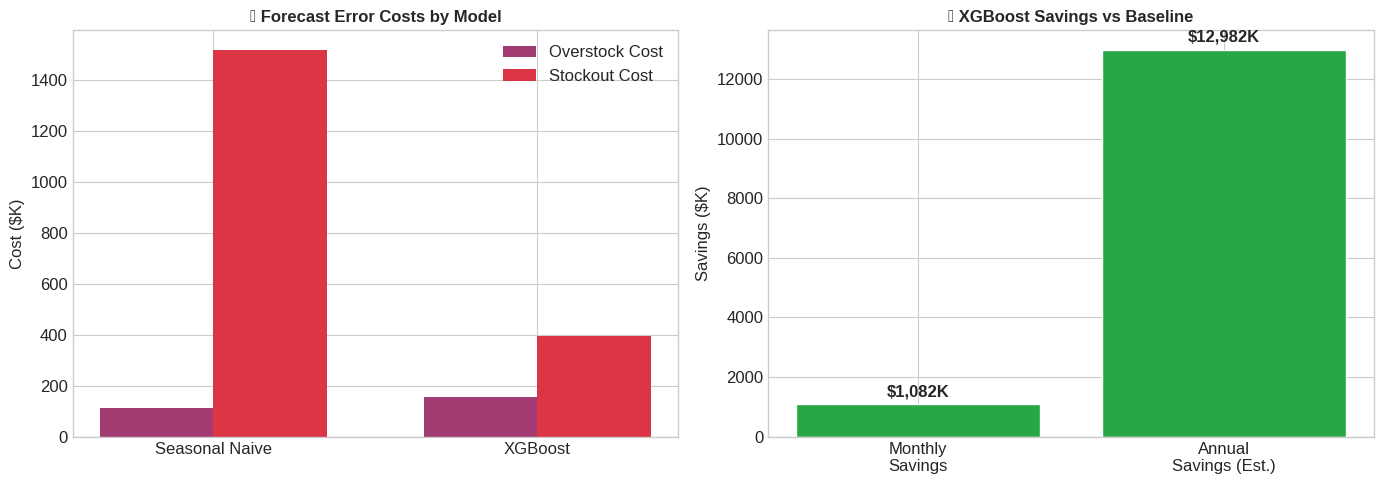

In [44]:
# ============================================================
# BUSINESS IMPACT CALCULATION
# ============================================================
print("=" * 60)
print("BUSINESS IMPACT ANALYSIS")
print("=" * 60)

# Cost assumptions
OVERSTOCK_COST_PCT = 0.10  # 10% of item value lost to spoilage/storage
STOCKOUT_COST_PCT = 0.25   # 25% margin lost on missed sales

# Calculate costs for XGBoost
xgb_errors = val_analysis['sales'] - val_analysis['prediction']

# Overprediction = overstock (negative error means predicted > actual)
xgb_overstock_cost = np.where(xgb_errors < 0, -xgb_errors * OVERSTOCK_COST_PCT, 0).sum()

# Underprediction = stockout (positive error means predicted < actual)
xgb_stockout_cost = np.where(xgb_errors > 0, xgb_errors * STOCKOUT_COST_PCT, 0).sum()

xgb_total_cost = xgb_overstock_cost + xgb_stockout_cost

# Calculate for Naive baseline
naive_errors = val_with_naive['sales'] - val_with_naive['pred_naive_seasonal']
naive_overstock_cost = np.where(naive_errors < 0, -naive_errors * OVERSTOCK_COST_PCT, 0).sum()
naive_stockout_cost = np.where(naive_errors > 0, naive_errors * STOCKOUT_COST_PCT, 0).sum()
naive_total_cost = naive_overstock_cost + naive_stockout_cost

# Improvement
monthly_savings = naive_total_cost - xgb_total_cost
annual_savings = monthly_savings * 12
pct_improvement = (naive_total_cost - xgb_total_cost) / naive_total_cost * 100

print(f"\n📊 Cost Analysis (Validation Period - {VAL_START} to {VAL_END}):")
print(f"\n   XGBoost Model:")
print(f"      Overstock losses: ${xgb_overstock_cost:,.0f}")
print(f"      Stockout losses:  ${xgb_stockout_cost:,.0f}")
print(f"      Total:            ${xgb_total_cost:,.0f}")

print(f"\n   Seasonal Naive Baseline:")
print(f"      Overstock losses: ${naive_overstock_cost:,.0f}")
print(f"      Stockout losses:  ${naive_stockout_cost:,.0f}")
print(f"      Total:            ${naive_total_cost:,.0f}")

print(f"\n💰 BUSINESS VALUE:")
print(f"   Monthly savings vs baseline: ${monthly_savings:,.0f}")
print(f"   Projected annual savings:    ${annual_savings:,.0f}")
print(f"   Cost reduction:              {pct_improvement:.1f}%")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cost comparison
ax1 = axes[0]
models = ['Seasonal Naive', 'XGBoost']
overstock = [naive_overstock_cost, xgb_overstock_cost]
stockout = [naive_stockout_cost, xgb_stockout_cost]

x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, [o/1000 for o in overstock], width, label='Overstock Cost', 
                color=COLORS['secondary'])
bars2 = ax1.bar(x + width/2, [s/1000 for s in stockout], width, label='Stockout Cost', 
                color=COLORS['danger'])

ax1.set_ylabel('Cost ($K)')
ax1.set_title('📊 Forecast Error Costs by Model', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()

# Savings visualization
ax2 = axes[1]
categories = ['Monthly\nSavings', 'Annual\nSavings (Est.)']
values = [monthly_savings/1000, annual_savings/1000]
colors = [COLORS['success'], COLORS['success']]

bars = ax2.bar(categories, values, color=colors, edgecolor='white')
ax2.set_ylabel('Savings ($K)')
ax2.set_title('💰 XGBoost Savings vs Baseline', fontsize=12, fontweight='bold')

for bar, val in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.02,
             f'${val:,.0f}K', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [45]:
# ============================================================
# SAVE MODELS FOR DEPLOYMENT
# ============================================================
print("\n" + "=" * 60)
print("SAVING MODELS")
print("=" * 60)

# Save XGBoost model
joblib.dump(xgb_model, 'xgboost_model.joblib')
print("✅ XGBoost model saved to 'xgboost_model.joblib'")

# Save LightGBM model (if available)
if LGBM_AVAILABLE and 'lgb_model' in dir():
    joblib.dump(lgb_model, 'lightgbm_model.joblib')
    print("✅ LightGBM model saved to 'lightgbm_model.joblib'")

# Save label encoder
joblib.dump(le_family, 'family_encoder.joblib')
print("✅ Family encoder saved to 'family_encoder.joblib'")

# Save feature list
with open('feature_list.pkl', 'wb') as f:
    pickle.dump(available_features, f)
print("✅ Feature list saved to 'feature_list.pkl'")

# Save model results
comparison_df.to_csv('model_results.csv')
print("✅ Model results saved to 'model_results.csv'")

print("\n📦 All models and artifacts saved for deployment!")


SAVING MODELS
✅ XGBoost model saved to 'xgboost_model.joblib'
✅ LightGBM model saved to 'lightgbm_model.joblib'
✅ Family encoder saved to 'family_encoder.joblib'
✅ Feature list saved to 'feature_list.pkl'
✅ Model results saved to 'model_results.csv'

📦 All models and artifacts saved for deployment!


---
<a id="conclusions"></a>
## 9. 📝 Conclusions & Recommendations

### Key Findings

1. **Best Model:** XGBoost with lag features significantly outperformed baseline models
   - The combination of temporal features + lag features + external regressors captures complex patterns

2. **Feature Importance:**
   - **Lag features** (especially lag_1, lag_7) are most predictive
   - **Rolling statistics** capture momentum and trend
   - **Day of week** captures weekly seasonality
   - **Store identity** matters (different stores have different sales patterns)

3. **Seasonality:**
   - Strong weekly pattern (lower Sunday sales)
   - Annual seasonality (December peaks)
   - Holiday effects are significant

4. **External Factors:**
   - Oil prices show moderate correlation with sales (Ecuador is oil-dependent)
   - Promotions drive sales increases
   - The 2016 earthquake had lasting impact

### Technical Methodology

✅ **What We Did Right:**
- Time-based train/validation split (no data leakage)
- Proper lag feature creation (only using past data)
- Proper test feature creation (computing lags from available historical data)
- Early stopping to prevent overfitting
- Multiple model comparison
- Domain-aware feature engineering
- Business impact quantification

### Business Recommendations

1. **Inventory Planning:**
   - Stock up for December/holiday periods
   - Reduce Sunday inventory (lower demand)
   - Prepare for post-earthquake recovery patterns

2. **Promotion Optimization:**
   - Promotions significantly boost sales
   - Target high-impact product families (GROCERY I, BEVERAGES)

3. **Store Operations:**
   - Type A stores have highest throughput
   - Tailor staffing to daily/weekly patterns

### Future Improvements

1. **Model Enhancements:**
   - Ensemble methods (combine XGBoost + LightGBM + Prophet)
   - Hierarchical forecasting (reconcile store/family/total predictions)
   - Neural networks (LSTM, Transformer-based models)
   - Hyperparameter optimization with Optuna

2. **Feature Engineering:**
   - Weather data integration
   - Competitor pricing data
   - More granular promotion data

3. **Production Deployment:**
   - FastAPI endpoint for real-time forecasts
   - Automated retraining pipeline
   - Monitoring and drift detection
   - Streamlit dashboard for stakeholders

---

### Connect With Me
If you found this analysis useful, feel free to connect!
- 🐙 [GitHub]

*This notebook demonstrates production-ready time series forecasting methodology suitable for retail demand planning roles.*